# Inner Core Lightning Threshold Analysis
In this notebook, we define the threshold for what constitutes a "lightning burst" in the inner core of a tropical cyclone. 

### How do we define a burst of lightning?
We define a lightning burst based off the number of lightning instances in a 30-minute time bin.
We start by assuming the distribution of lightning in the inner core is Gaussian.

*We look at each basin separately. Below are the basin codes:
* ATL - Atlantic Ocean basin
* CPAC - 
* EPAC - Eastern Pacific basin
* IO - Indian Ocean basin
* SHEM - Southern Hemisphere basin
* WPAC - Western North Pacific basin

## Code
### Import Libraries and Files
Let's start by importing necessary libraries and files. The inner core dataset is created in the `data_processing.ipynb` notebook as `innercore_timebin_joined.csv`.

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import median_abs_deviation
import matplotlib.patches as mpatches

In [2]:
# import data from csv file
innercore_data = pl.read_csv("data_pipeline/innercore_timebin_joined.csv")
innercore_data = innercore_data.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"),
    pl.col("lightning_count").log1p().alias("log_lightning_count"),
    pl.when(pl.col("pressure") == 0)
    .then(None)  # Replace 0 with None -> 0 is not possible, treat these as null but don't remove row bc the wind speed value is valid
    .otherwise(pl.col("pressure"))
    .alias("pressure")  # Keep the column name as "pressure"
)
innercore_data = innercore_data.with_columns(
    pl.when(pl.col("TC_Category") == "Unidentified")
    .then(pl.lit("0")) # Replace "unidentified" with 0 for current category
    .otherwise(pl.col("TC_Category"))
    .alias("TC_Category")
)
innercore_data = innercore_data.rename({"Intensification_Category":"Intensification_Category_5", "TC_Category":"Current_Category"})
innercore_data.head()

time_bin,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,pressure,knots,storm_name,category,basin,minute_right,24_hour_knots_diff,24_hour_pressure_diff,Current_Category,Intensification_Category_5,log_lightning_count
datetime[μs],str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,str,i64,str,i64,f64,f64,str,str,f64
2010-06-21 07:00:00,"""ATL_10_1""",1,2010,6,21,7,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.693147
2010-06-21 07:30:00,"""ATL_10_1""",0,2010,6,21,7,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0
2010-06-21 08:00:00,"""ATL_10_1""",0,2010,6,21,8,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0
2010-06-21 08:30:00,"""ATL_10_1""",0,2010,6,21,8,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0
2010-06-21 09:00:00,"""ATL_10_1""",0,2010,6,21,9,0,14.0,-67.6,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0


We map the intensification bins into 3, combining the rapidly weakening and weakening bins, and the rapidly intensifying and intensifying bins.

In [3]:
# Mapping intensification bins into 3 category instead of 5
category_mapping = {
    "Rapidly Weakening": "Weakening",
    "Weakening": "Weakening",
    "Neutral": "Neutral",
    "Intensifying": "Intensifying",
    "Rapidly Intensifying": "Intensifying"
}

# Apply mapping to create new column
innercore_data = innercore_data.with_columns(
    innercore_data["Intensification_Category_5"].replace(category_mapping).alias("Intensification_Category_3")
)

innercore_data.head()

time_bin,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,pressure,knots,storm_name,category,basin,minute_right,24_hour_knots_diff,24_hour_pressure_diff,Current_Category,Intensification_Category_5,log_lightning_count,Intensification_Category_3
datetime[μs],str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,str,i64,str,i64,f64,f64,str,str,f64,str
2010-06-21 07:00:00,"""ATL_10_1""",1,2010,6,21,7,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.693147,"""Neutral"""
2010-06-21 07:30:00,"""ATL_10_1""",0,2010,6,21,7,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0,"""Neutral"""
2010-06-21 08:00:00,"""ATL_10_1""",0,2010,6,21,8,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0,"""Neutral"""
2010-06-21 08:30:00,"""ATL_10_1""",0,2010,6,21,8,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0,"""Neutral"""
2010-06-21 09:00:00,"""ATL_10_1""",0,2010,6,21,9,0,14.0,-67.6,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0,"""Neutral"""


In [4]:
# Create dataframe for filtering later
storm_names = innercore_data[["storm_code", "storm_name"]].unique()

### Functions

Below are the functions used to evaluate 6 different lightning burst thresholds at the individual TC level. We compare each TC's lightning to itself to identify a burst using the IQR, MAD, and Lognormal methods. The thresholds defined by each of these functions act as a standard for a lightning burst for that TC. If the count in the bin is more than the threshold, we mark it as a lightning burst. Note that we use log-transformed lightning counts in this analysis. We do not include data associated with current wind speeds less than 40 knots in this threshold analysis. 

We also create functions to apply the thresholds and aggregate results, as well as functions used to plot individual TCs for analysis.

In [5]:
# IQR threshold function
def detect_bursts_iqr(group):
    Q1 = group['log_lightning_count'].quantile(0.25)
    Q3 = group['log_lightning_count'].quantile(0.75)
    IQR = Q3 - Q1

    # Set burst threshold for each cyclone individually
    threshold1 = Q3 + 1 * IQR
    threshold2 = Q3 + 1.5* IQR

    # Mark bursts specific to the cyclone
    group['burst_iqr1'] = group['log_lightning_count'] > threshold1
    group['burst_iqr2'] = group['log_lightning_count'] > threshold2
    group['iqr1_threshold'] = threshold1
    group['iqr2_threshold'] = threshold2
    return group

In [6]:
# MAD threshold function
def detect_bursts_mad(group):
    median_log = group['log_lightning_count'].median()
    mad_log = median_abs_deviation(group['log_lightning_count'])

    # Set burst threshold based on MAD for each cyclone
    threshold1 = median_log + 4 * mad_log
    threshold2 = median_log + 5 * mad_log

    # Mark bursts specific to the cyclone
    group['burst_mad1'] = group['log_lightning_count'] > threshold1
    group['burst_mad2'] = group['log_lightning_count'] > threshold2
    group['mad1_threshold'] = threshold1
    group['mad2_threshold'] = threshold2
    return group

In [7]:
# Log normal threshold function
def detect_bursts_lognormal(group):
     # Calculate the mean and standard deviation of the log-transformed lightning count
    mean_log = group['log_lightning_count'].mean()
    std_log = group['log_lightning_count'].std()

    # Set burst thresholds based on log-normal distribution (mean + 2σ and mean + 3σ)
    threshold1 = mean_log + 2 * std_log
    threshold2 = mean_log + 3 * std_log

    # Mark bursts specific to the cyclone
    group['burst_logn1'] = group['log_lightning_count'] > threshold1
    group['burst_logn2'] = group['log_lightning_count'] > threshold2
    group['logn1_threshold'] = threshold1
    group['logn2_threshold'] = threshold2
    return group

In [25]:
# Function to apply the 3 methods, 6 thresholds for individual TCs
def apply_individual_thresholds(df):
    bursts = df.groupby(["storm_code"]).apply(detect_bursts_iqr)
    bursts.reset_index(drop=True, inplace=True)
    bursts = bursts.groupby(["storm_code"]).apply(detect_bursts_mad)
    bursts.reset_index(drop=True, inplace=True)
    bursts = bursts.groupby(["storm_code"]).apply(detect_bursts_lognormal)
    bursts.reset_index(drop=True, inplace=True)
    # Reset index to keep data points in chronological order
    bursts.sort_values(by=["storm_code", "time_bin"], inplace=True)
    bursts.reset_index(drop=True, inplace=True)
    return bursts

In [34]:
# Function used to aggregate results dataframe
def create_tc_summary(processed):
    tc_summary = processed.groupby(["storm_code"]).agg(
        mad1_bursts=('burst_mad1', 'sum'),
        mad2_bursts=('burst_mad2', 'sum'),
        mad1_threshold=('mad1_threshold', 'max'),
        mad2_threshold=('mad2_threshold', 'max'),
        iqr1_bursts=('burst_iqr1', 'sum'),
        iqr2_bursts=('burst_iqr2', 'sum'),
        iqr1_threshold=('iqr1_threshold', 'max'),
        iqr2_threshold=('iqr2_threshold', 'max'),
        logn1_bursts=('burst_logn1', 'sum'),
        logn2_bursts=('burst_logn2', 'sum'),
        logn1_threshold=('logn1_threshold', 'max'),
        logn2_threshold=('logn2_threshold', 'max'),
        total_bins=('storm_code', 'count')
    )
    tc_summary.reset_index(drop=False, inplace=True)
    tc_summary.head(10)

    tc_summary["mad1_prop"] = round((tc_summary["mad1_bursts"]/tc_summary["total_bins"])*100, 2)
    tc_summary["mad2_prop"] = round((tc_summary["mad2_bursts"]/tc_summary["total_bins"])*100, 2)
    tc_summary["iqr1_prop"] = round((tc_summary["iqr1_bursts"]/tc_summary["total_bins"])*100, 2)
    tc_summary["iqr2_prop"] = round((tc_summary["iqr2_bursts"]/tc_summary["total_bins"])*100, 2)
    tc_summary["logn1_prop"] = round((tc_summary["logn1_bursts"]/tc_summary["total_bins"])*100, 2)
    tc_summary["logn2_prop"] = round((tc_summary["logn2_bursts"]/tc_summary["total_bins"])*100, 2)
    return tc_summary

In [10]:
def add_bg_colors(ax, lightning_data, color_type):
    """
    Adds background shading based on either the 'Intensification_Category_3' column or 'Current_Category' column.

    Parameters:
    - ax: The matplotlib axis to plot on.
    - lightning_data: DataFrame with 'time_bin', 'Intensification_Category_3', and 'Current_Category'
    - color_type: toggle between coloring by intensification change category or current category, can only take i3, i5, c5 as values
    """
    # Define color mapping
    i3_colors = {
        "Intensifying": "#FFEE8C",
        "Neutral": "lightgreen",
        "Weakening": "lightblue",
        "Unidentified":"white"
    }
    i5_colors = {
        "Rapidly Intensifying": "#f6aeae",
        "Intensifying": "#FFEE8C",
        "Neutral": "lightgreen",
        "Weakening": "lightblue",
        "Rapidly Weakening": "#dab1da",
        "Unidentified":"white"
    }
    c5_colors = {
        "0":'white',
        "1":'#FFEE8C',
        "2":'lightgreen',
        "3":'lightblue',
        "4":'#dab1da',
        "5":'pink'
    }

    # Define color_type toggle
    color_type_toggle = {
        "i3":["Intensification_Category_3", i3_colors],
        "i5":["Intensification_Category_5", i5_colors],
        "c5":["Current_Category", c5_colors]
    }
    # Exit if inputted color type is not valid
    if color_type not in color_type_toggle.keys():
        return(print(f"Not a valid background color type. Choose either: {', '.join(color_type_toggle.keys())}"))

    category_colors = color_type_toggle[color_type][1]
    column_name = color_type_toggle[color_type][0]
    for i in range(len(lightning_data) - 1):
        category = lightning_data[column_name].iloc[i]
        color = category_colors.get(category, "red")  # Default to red if not found - flag this as an error

        ax.axvspan(lightning_data['time_bin'].iloc[i],
                   lightning_data['time_bin'].iloc[i + 1],
                   color=color, alpha=0.3)

    # Create custom legend patches
    legend_patches = [mpatches.Patch(color=c, label=cat) for cat, c in category_colors.items()]
    return legend_patches  # Return legend handles

In [11]:
def plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, bg_type):
    cyclone_name = storm_names.filter(pl.col("storm_code") == cyclone_id)["storm_name"].item()
    df_cyclone = processed[processed['storm_code'] == cyclone_id]
    lightning_data = innercore_data.filter(pl.col("storm_code") == cyclone_id).to_pandas()

    plt.figure(figsize=(10, 5))

    # Create first y-axis for lightning
    fig, ax1 = plt.subplots(figsize=(14, 8))

    ax1.plot(lightning_data['time_bin'], lightning_data['lightning_count'], label='Lightning Count', color='gray')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Lightning Count", color="gray")
    ax1.tick_params(axis='y', labelcolor="gray")

    # Create second y-axis for pressure
    ax2 = ax1.twinx()
    ax2.plot(lightning_data['time_bin'], lightning_data['pressure'], label='Pressure', color='orange')
    ax2.set_ylabel("Pressure", color="orange")
    ax2.tick_params(axis='y', labelcolor="orange")

    # Create third y-axis for wind knot
    ax2 = ax1.twinx()
    ax2.plot(lightning_data['time_bin'], lightning_data['knots'], label='Wind', color='blue')
    ax2.set_ylabel("Wind", color="blue")
    ax2.tick_params(axis='y', labelcolor="blue")

    # Call bg colors function
    legend_patches = add_bg_colors(ax1, lightning_data, bg_type)

    # Mark bursts detected by MAD
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad1']],
                df_cyclone['lightning_count'][df_cyclone['burst_mad1']],
                color='red', label='MAD Detected Burst -threshold1', s=50, marker='o', alpha=0.7)
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad2']],
                df_cyclone['lightning_count'][df_cyclone['burst_mad2']],
                color='yellow', label='MAD Detected Burst - threshold2', s=50, marker='o', alpha=0.7)

    # Mark bursts detected by IQR
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr1']],
                df_cyclone['lightning_count'][df_cyclone['burst_iqr1']],
                color='blue', label='IQR Detected Burst - threshold1', s=50, marker='x', alpha=0.7)
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr2']],
                df_cyclone['lightning_count'][df_cyclone['burst_iqr2']],
                color='green', label='IQR Detected Burst - threshold2', s=50, marker='x', alpha=0.7)

    # Mark bursts detected by lognormal threshold
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_logn1']],
                df_cyclone['lightning_count'][df_cyclone['burst_logn1']],
                color='purple', label='Lognormal Detected Burst - 2 sigma', s=50, marker='^', alpha=0.7)
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_logn2']],
                df_cyclone['lightning_count'][df_cyclone['burst_logn2']],
                color='orange', label='Lognormal Detected Burst - 3 sigma', s=50, marker='^', alpha=0.7)

    plt.xlabel('Time')
    plt.title(f'Lightning Burst Detection for {cyclone_name} ({cyclone_id})')
    ax1.legend(loc='upper left')
    ax2.legend(handles=legend_patches, loc='center left')
    plt.xticks(visible=False)
    plt.grid()
    plt.show()

In [27]:
def group_bins_category(dataset):
    # split bins into 0-2, 1-2, and 3-5 categories - return 3 datasets
    weak_cat0 = ["0", "1", "2"]
    weak_cat1 = ["1", "2"]
    strong_cat = ["3", "4", "5"]

    # separate the 2 category groupings
    weak0_lightning = dataset[dataset["Current_Category"].isin(weak_cat0)]
    print(f"{len(weak0_lightning)} non-zero lightning count timebins associated with category {min(weak_cat0)}-{max(weak_cat0)} wind speeds in EPAC basin.")

    weak1_lightning = dataset[dataset["Current_Category"].isin(weak_cat1)]
    print(f"{len(weak1_lightning)} non-zero lightning count timebins associated with category {min(weak_cat1)}-{max(weak_cat1)} wind speeds in EPAC basin.")

    strong_lightning = dataset[dataset["Current_Category"].isin(strong_cat)]
    print(f"{len(strong_lightning)} non-zero lightning count timebins associated with category {min(strong_cat)}-{max(strong_cat)} wind speeds in EPAC basin.")

    return weak0_lightning, weak1_lightning, strong_lightning

In [19]:
def plot_threshold_histogram(dataset, threshold_type, ax=None):
    if ax is None: # enable plotting multiple in a grid if ax passed in
        fig, ax = plt.subplots()
    threshold_names = {
        'mad1':['mad1_threshold','MAD1'],
        'mad2':['mad2_threshold','MAD2'],
        'iqr1':['iqr1_threshold','IQR1'],
        'iqr2':['iqr2_threshold','IQR2'],
        'logn1':['logn1_threshold','Lognormal 2 Sigma'],
        'logn2':['logn2_threshold','Lognormal 3 Sigma'],
    }
    if ax is None:
        fig, ax = plt.subplots()
    plot_data = dataset[threshold_names[threshold_type][0]]
    if plot_data is None or len(plot_data) == 0 or sum(plot_data.isnull()) == len(plot_data):  # Check if data is empty
        ax.text(0.5, 0.5, "No Data Available", fontsize=12, ha='center', va='center')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([])  # Hide x-axis ticks
        ax.set_yticks([])  # Hide y-axis ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(f"Histogram of {threshold_names[threshold_type][1]} Burst Threshold")
    else:
        ax.hist(plot_data, bins=20, edgecolor="black", align="left")
        ax.set_xlabel("Lightning Burst Threshold (Log10 Scale)")
        ax.set_ylabel("Frequency")
        ax.set_title(f"Histogram of {threshold_names[threshold_type][1]} Burst Threshold")

In [14]:
def plot_threshold_boxplot(dataset, category_group, ax=None):
    plt.figure(figsize=(10, 6))
    plt.boxplot([dataset['mad1_threshold'], dataset['mad2_threshold'], dataset['iqr1_threshold'],
                dataset['iqr2_threshold'], dataset['logn1_threshold'], dataset['logn2_threshold']]
                , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
                patch_artist=True, boxprops=dict(facecolor='lightgreen'))

    plt.title(f'Threshold Value Comparison - {category_group}')
    plt.ylabel('Values')

    plt.show()

In [15]:
def create_burst_summary(dataset):
    threshold_names = {
        'mad1':['mad1_threshold','MAD1'],
        'mad2':['mad2_threshold','MAD2'],
        'iqr1':['iqr1_threshold','IQR1'],
        'iqr2':['iqr2_threshold','IQR2'],
        'logn1':['logn1_threshold','Lognormal 2 Sigma'],
        'logn2':['logn2_threshold','Lognormal 3 Sigma'],
    }
    threshold_keys = list(threshold_names.keys())
    burst_labels = [f'burst_{key}' for key, value in threshold_names.items()]
    # Generate burst summary
    burst_summary = {
        "Threshold": threshold_keys,
        "Burst Count": [dataset[b].sum() for b in burst_labels],
        "Timebin Count": [dataset["time_bin"].count() for i in range(len(burst_labels))],
        "Burst Percentage": [round(dataset[b].sum()/dataset["time_bin"].count()*100, 2) for b in burst_labels]
    }
    burst_summary = pd.DataFrame(burst_summary)
    return burst_summary

In [16]:
def create_basin_summary(dataset, category_group, basin):
    valid_categories = ["0-2", "1-2", "3-5", "all"]
    valid_basins = ["ATL", "EPAC", "WPAC", "IO", "SHEM", "CPAC"]
    threshold_names = {
        'mad1':['mad1_threshold','MAD1'],
        'mad2':['mad2_threshold','MAD2'],
        'iqr1':['iqr1_threshold','IQR1'],
        'iqr2':['iqr2_threshold','IQR2'],
        'logn1':['logn1_threshold','Lognormal 2 Sigma'],
        'logn2':['logn2_threshold','Lognormal 3 Sigma'],
    }
    threshold_keys = list(threshold_names.keys())
    threshold_cols = [threshold_names[key][0] for key in threshold_keys]

    # Check for valid input
    if category_group not in valid_categories:
        return(print(f"Not a valid category grouping. Choose either: {', '.join(valid_categories)}"))
    elif basin not in valid_basins:
        return(print(f"Not a valid basin. Choose either: {', '.join(valid_basins)}"))

    burst_summary = create_burst_summary(dataset)

    # Get mean and 2 standard deviations - threshold summary
    threshold_summary = {
        "Basin": [basin for i in range(len(threshold_keys))],
        "Category Group": [category_group for i in range(len(threshold_keys))],
        "Threshold": threshold_keys,
        "Mean": [dataset[col].mean() for col in threshold_cols],
        "Std Dev": [dataset[col].std() for col in threshold_cols],
        "Median": [dataset[col].median() for col in threshold_cols],
        "Min": [dataset[col].min() for col in threshold_cols],
        "Max": [dataset[col].max() for col in threshold_cols],
        "Basin-Category Threshold (Mean-Based)": [dataset[col].mean()+2*dataset[col].std() for col in threshold_cols], # mean + 2 standard deviations
        "Basin-Category Threshold (Median-Based)": [dataset[col].median()+2*dataset[col].std() for col in threshold_cols], # median + 2 standard deviations
    }
    threshold_summary = pd.DataFrame(threshold_summary)
    threshold_summary

    # Join the two dataframes and return
    return pd.merge(threshold_summary, burst_summary, on="Threshold")

In [17]:
def create_basin_threshold_dict(summary_data):
    basin_thresholds_mean = {}
    for i in range(len(summary_data)):
        basin_thresholds_mean[summary_data["Threshold"][i]] = summary_data["Basin-Category Threshold (Mean-Based)"][i]
    basin_thresholds_median = {}
    for i in range(len(summary_data)):
        basin_thresholds_median[summary_data["Threshold"][i]] = summary_data["Basin-Category Threshold (Median-Based)"][i]

    return basin_thresholds_mean, basin_thresholds_median

In [20]:
def detect_bursts_basin(group, thresholds):

    # Use thresholds passed in as dictionary
    for key, value in thresholds.items():
        threshold = value
        group[f'burst_{key}'] = group['log_lightning_count'] > threshold
        group[f'{key}_threshold'] = threshold

    return group

In [28]:
def apply_basin_thresholds(df, basin_thresholds):
    # drop bins with 0 lightning count
    clean_data = df[df['lightning_count'] != 0]

    bursts = clean_data.groupby(["storm_code"]).apply(detect_bursts_basin, thresholds = basin_thresholds)
    bursts.reset_index(drop=True, inplace=True)

    bursts.sort_values(by=["storm_code", "time_bin"], inplace=True)
    bursts.reset_index(drop=True, inplace=True)

    return bursts

In [22]:
def column_rename_helper(threshold_type=None):
    column_names = {
        "mean": {"Burst Count": "Mean-Based Threshold Bursts",
                "Burst Percentage":"Mean-Based Threshold Burst Percentage"},
        "median":{"Burst Count": "Median-Based Threshold Bursts",
                  "Burst Percentage":"Median-Based Threshold Burst Percentage"}
    }
    if threshold_type == "effective":
        column_names = {
            "mean": {"Burst Count": "Mean-Based Effective Threshold Bursts",
                    "Burst Percentage":"Mean-Based Effective Threshold Burst Percentage"},
            "median":{"Burst Count": "Median-Based Effective Threshold Bursts",
                    "Burst Percentage":"Median-Based Effective Threshold Burst Percentage"}
        }
    return column_names

In [ ]:
def summarize_threshold_eval(summary_data, lightning_data, threshold_data=None, threshold_type=None):

    # Create threshold dictionaries to apply at basin level (categories 3-5)
    if threshold_data is not None:
        mean_thresholds, median_thresholds = create_basin_threshold_dict(threshold_data)
    else:
        mean_thresholds, median_thresholds = create_basin_threshold_dict(summary_data)

    # Create agg results at individual TC level for the mean and median threshold methods
    bursts_mean = apply_basin_thresholds(lightning_data, mean_thresholds)
    tc_summary_mean = create_tc_summary(bursts_mean)

    bursts_median = apply_basin_thresholds(lightning_data, median_thresholds)
    tc_summary_median = create_tc_summary(bursts_median)

    # Create burst summary at basin level
    column_names = column_rename_helper(threshold_type)
    burst_summary_mean = create_burst_summary(bursts_mean)
    burst_summary_mean = burst_summary_mean.rename(columns=column_names["mean"])

    burst_summary_median = create_burst_summary(bursts_median)
    burst_summary_median = burst_summary_median.rename(columns=column_names["median"])

    # Add to the basin summary
    if threshold_type == "effective" and threshold_data is not None:
        threshold_data_temp = threshold_data[["Threshold", "Basin-Category Threshold (Mean-Based)", "Basin-Category Threshold (Median-Based)"]].rename(
            columns={"Basin-Category Threshold (Mean-Based)": "Basin-Category Effective Threshold (Mean-Based)",
            "Basin-Category Threshold (Median-Based)": "Basin-Category Effective Threshold (Median-Based)"}
            )
        summary_data = pd.merge(summary_data, threshold_data_temp, on="Threshold")
    summary_data = pd.merge(summary_data, burst_summary_mean[["Threshold", column_names["mean"]["Burst Count"], column_names["mean"]["Burst Percentage"]]], on="Threshold")
    summary_data = pd.merge(summary_data, burst_summary_median[["Threshold", column_names["median"]["Burst Count"], column_names["median"]["Burst Percentage"]]], on="Threshold")

    return summary_data, bursts_mean, tc_summary_mean, bursts_median, tc_summary_median

---------------------

### Individual TC Analysis
We start by applying the 6 different thresholds to each TC individually, where we evaluate burst thresholds in comparison to a TC's own lightning activity for time bins associated with wind speeds greater than or equal to 40 knots. We start by filtering out data associated with wind speeds less than 40 knots.

In [29]:
# Filter out data where wind is less than 40 knots for threshold analysis
analysis_data = innercore_data.filter(pl.col("knots") >= 40)
# Convert polars dataframe to pandas for application of functions
pd_data = analysis_data.to_pandas()

We then apply the functions to the data, including timebins with no lightning activity.

In [ ]:
# Apply functions to data, including bins with 0 lightning
bursts_w_0 = apply_individual_thresholds(pd_data)

tc_summary_w_0 = create_tc_summary(bursts_w_0)
tc_summary_w_0.head(10)

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
0,ATL_10_1,40,40,0.000000,0.000000,40,40,0.000000,0.000000,10,4,1.964998,2.766760,168,23.81,23.81,23.81,23.81,5.95,2.38
1,ATL_10_11,54,54,0.000000,0.000000,54,54,0.000000,0.000000,25,17,0.905833,1.299925,524,10.31,10.31,10.31,10.31,4.77,3.24
2,ATL_10_12,83,83,0.000000,0.000000,83,83,0.000000,0.000000,24,10,2.714949,3.820770,347,23.92,23.92,23.92,23.92,6.92,2.88
3,ATL_10_13,43,35,1.732868,2.079442,6,1,4.552490,5.690612,6,0,4.401910,5.986869,130,33.08,26.92,4.62,0.77,4.62,0.00
4,ATL_10_14,23,23,0.000000,0.000000,23,23,0.000000,0.000000,15,5,1.092380,1.547290,144,15.97,15.97,15.97,15.97,10.42,3.47
5,ATL_10_17,75,75,0.000000,0.000000,57,56,1.386294,1.732868,24,2,3.893827,5.435464,270,27.78,27.78,21.11,20.74,8.89,0.74
6,ATL_10_18,0,0,7.791445,9.023858,0,0,6.425564,7.595410,3,0,5.929778,7.469033,180,0.00,0.00,0.00,0.00,1.67,0.00
7,ATL_10_19,58,58,0.000000,0.000000,1,0,5.344880,6.681100,6,0,4.938227,6.723796,120,48.33,48.33,0.83,0.00,5.00,0.00
8,ATL_10_20,12,7,3.465736,4.158883,6,1,4.394449,5.493061,5,0,4.549465,6.195277,77,15.58,9.09,7.79,1.30,6.49,0.00
9,ATL_10_21,100,75,3.465736,4.158883,35,2,5.545177,6.931472,34,0,5.640493,7.671843,476,21.01,15.76,7.35,0.42,7.14,0.00


In [32]:
# Get mean threshold value for each of the 6 options
tc_summary_w_0_mean = tc_summary_w_0.drop(columns=("storm_code")).mean()
print(tc_summary_w_0_mean[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])
# Get median threshold value for each of the 6 options
tc_summary_w_0_median = tc_summary_w_0.drop(columns=("storm_code")).median()
print(tc_summary_w_0_median[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])

mad1_threshold     1.080206
mad2_threshold     1.289705
iqr1_threshold     2.292736
iqr2_threshold     2.859537
logn1_threshold    3.085677
logn2_threshold    4.239224
dtype: float64
mad1_threshold     0.000000
mad2_threshold     0.000000
iqr1_threshold     1.386294
iqr2_threshold     1.732868
logn1_threshold    2.925341
logn2_threshold    4.069471
dtype: float64


We can see that the threshold values are all very low, meaning that any lightning activity is likely to be flagged as a burst. We plot one TC below to look at a specific example. This can be expected, as we know that many of the timebins have no lightning activity, therefore skewing the threshold lower.

<Figure size 1000x500 with 0 Axes>

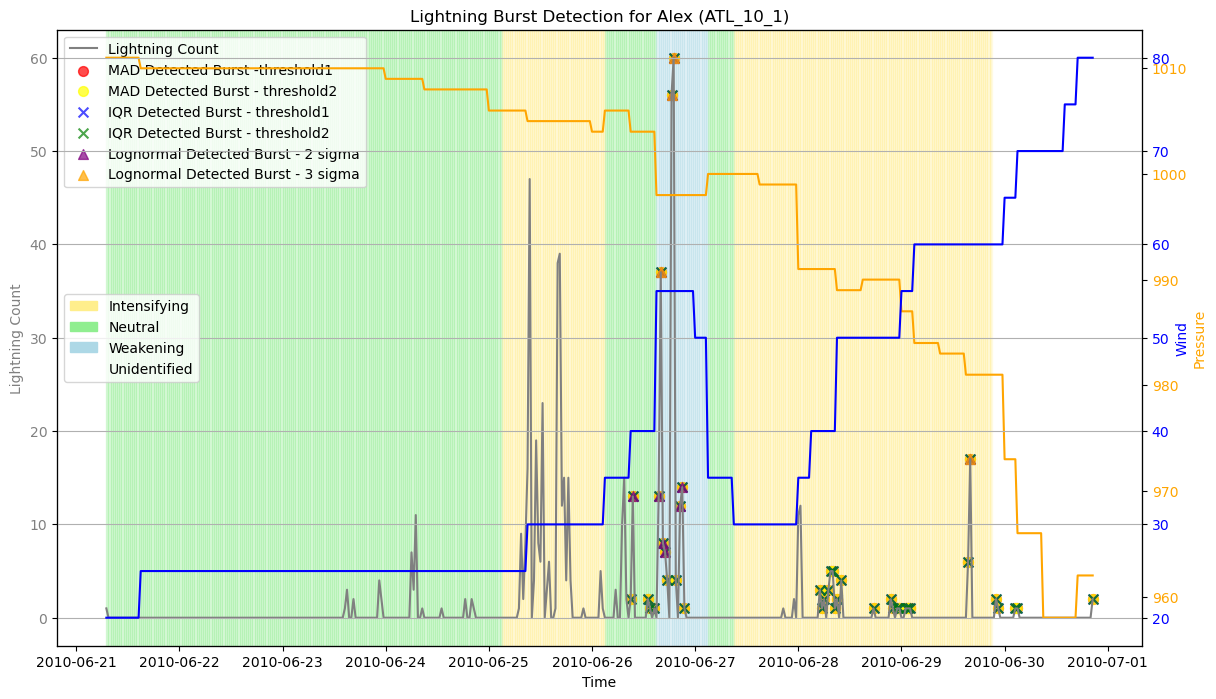

<Figure size 1000x500 with 0 Axes>

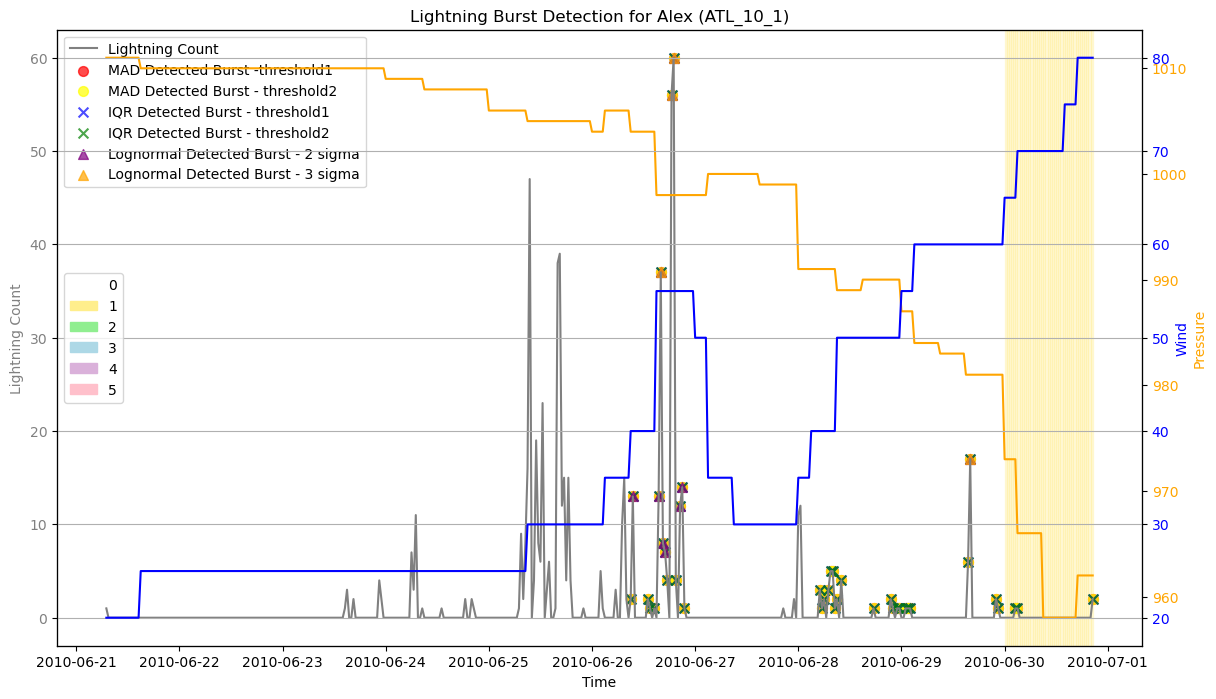

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
0,ATL_10_1,40,40,0.0,0.0,40,40,0.0,0.0,10,4,1.964998,2.76676,168,23.81,23.81,23.81,23.81,5.95,2.38


In [33]:
# ATL_10_1 with 0 in the analysis
cyclone_id = 'ATL_10_1'
plot_tc_intensification(cyclone_id, bursts_w_0, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, bursts_w_0, storm_names, innercore_data, "c5")
# Print the summary for this storm
tc_summary_w_0[tc_summary_w_0["storm_code"] == cyclone_id]

Next, we try applying the thresholds to the dataset without timebins with 0 lightning count. This slightly alters our definition of a lightning burst - we now compare each set of lightning events to other nonzero lightning events. This should bring up the threshold and bring down the percent of timebins flagged as a burst.

In [35]:
# Apply functions to data(exclude 0 lightning count)
pd_data_drop0 = pd_data[pd_data['lightning_count'] != 0]

bursts = apply_individual_thresholds(pd_data_drop0)

tc_summary = create_tc_summary(bursts)
tc_summary = pd.merge(storm_names.to_pandas(), tc_summary, on="storm_code")
tc_summary.head(10)

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
0,EPAC_13_8,Henriette,1,1,2.720473,3.125938,1,1,2.525729,2.983874,...,0,2.578337,3.229375,25,4.00,4.00,4.00,4.00,4.00,0.0
1,EPAC_19_15,Lorena,0,0,7.483536,8.677407,6,0,6.330050,7.510203,...,0,6.134410,7.753040,150,0.00,0.00,4.00,0.00,4.00,0.0
2,WPAC_13_31,Haiyan,0,0,7.927677,9.003533,0,0,6.695130,7.747685,...,0,6.443103,7.903738,212,0.00,0.00,0.00,0.00,0.00,0.0
3,EPAC_18_15,Miriam,0,0,7.790204,9.060743,0,0,6.484027,7.702674,...,0,5.883172,7.386922,88,0.00,0.00,0.00,0.00,1.14,0.0
4,WPAC_14_8,Neoguri,1,0,4.382027,5.075174,0,0,4.682131,5.578011,...,0,4.175207,5.315678,37,2.70,0.00,0.00,0.00,2.70,0.0
5,WPAC_11_20,Nesat,0,0,4.158883,4.852030,4,2,3.324330,3.982126,...,0,3.545976,4.515088,48,0.00,0.00,8.33,4.17,6.25,0.0
6,EPAC_11_5,Eugene,3,2,4.158883,4.852030,3,1,4.353224,5.268244,...,0,4.467112,5.769141,50,6.00,4.00,6.00,2.00,6.00,0.0
7,ATL_15_4,Danny,0,0,6.879356,7.977968,2,0,5.958941,7.046317,...,0,5.741565,7.258307,65,0.00,0.00,3.08,0.00,6.15,0.0
8,ATL_10_17,Otto,0,0,8.435549,9.821844,0,0,6.852734,8.140767,...,0,6.020799,7.572206,75,0.00,0.00,0.00,0.00,1.33,0.0
9,SHEM_15_13,Marcia,4,1,2.720473,3.125938,1,0,3.198673,3.825055,...,0,3.089479,3.885317,29,13.79,3.45,3.45,0.00,3.45,0.0


<Figure size 1000x500 with 0 Axes>

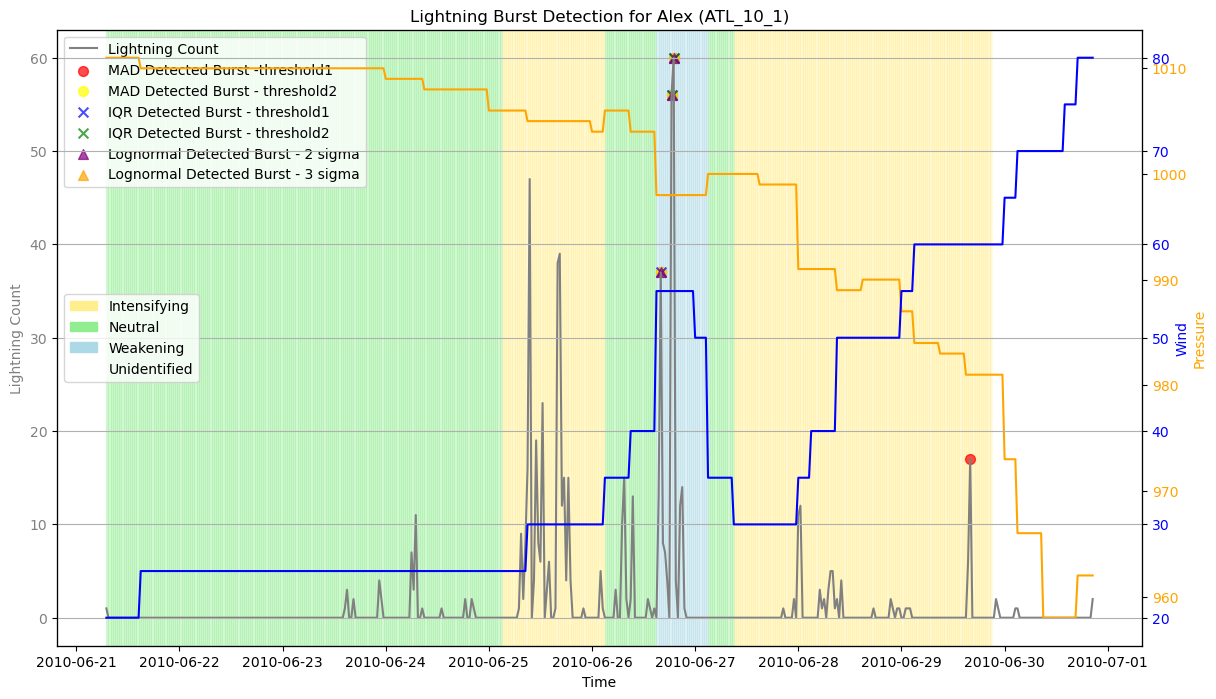

<Figure size 1000x500 with 0 Axes>

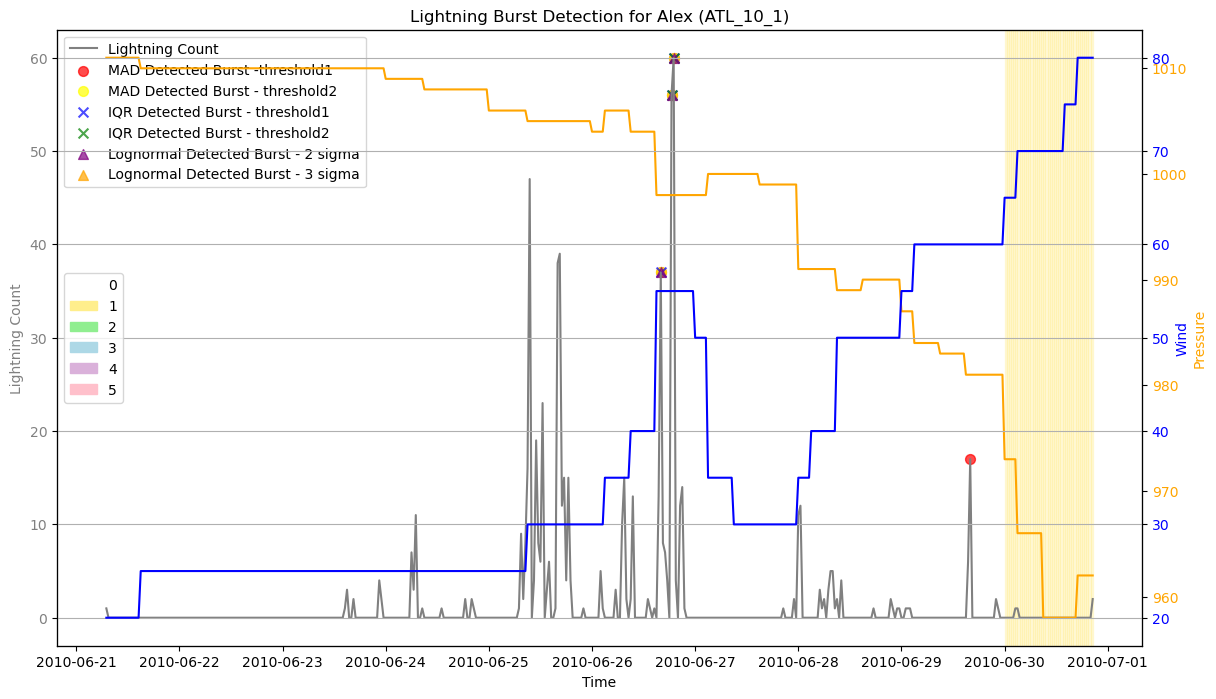

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
401,ATL_10_1,Alex,4,3,2.720473,3.125938,3,2,3.265439,3.908512,...,0,3.469047,4.444476,40,10.0,7.5,7.5,5.0,7.5,0.0


In [36]:
# ATL_10_1 without 0 in threshold calculation
cyclone_id = 'ATL_10_1'
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

We see above that the analysis including timebins with 0 lightning events skews the threshold to 0, such that any lightning event is flagged as a burst. This is not realistic, and so we will not include the timebins with 0 lightning events in our threshold analysis.

Below, we look at a couple more TCs. We plot the lightning, wind, pressure, all detected lightning bursts using the 6 thresholds created above, and their intensification category/current category bins as color-coded backgrounds. Note that all data is plotted, regardless of if the point was included in the analysis (we do not consider data points associated with winds less than 40 knots in our threshold analysis).

<Figure size 1000x500 with 0 Axes>

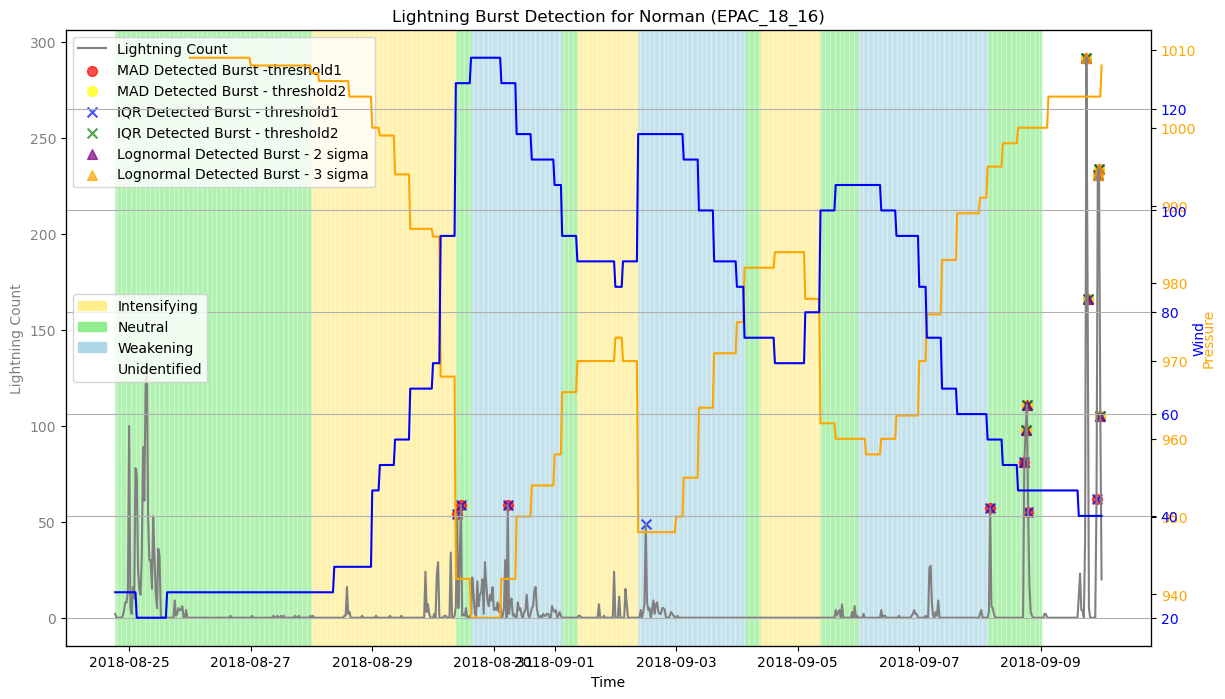

<Figure size 1000x500 with 0 Axes>

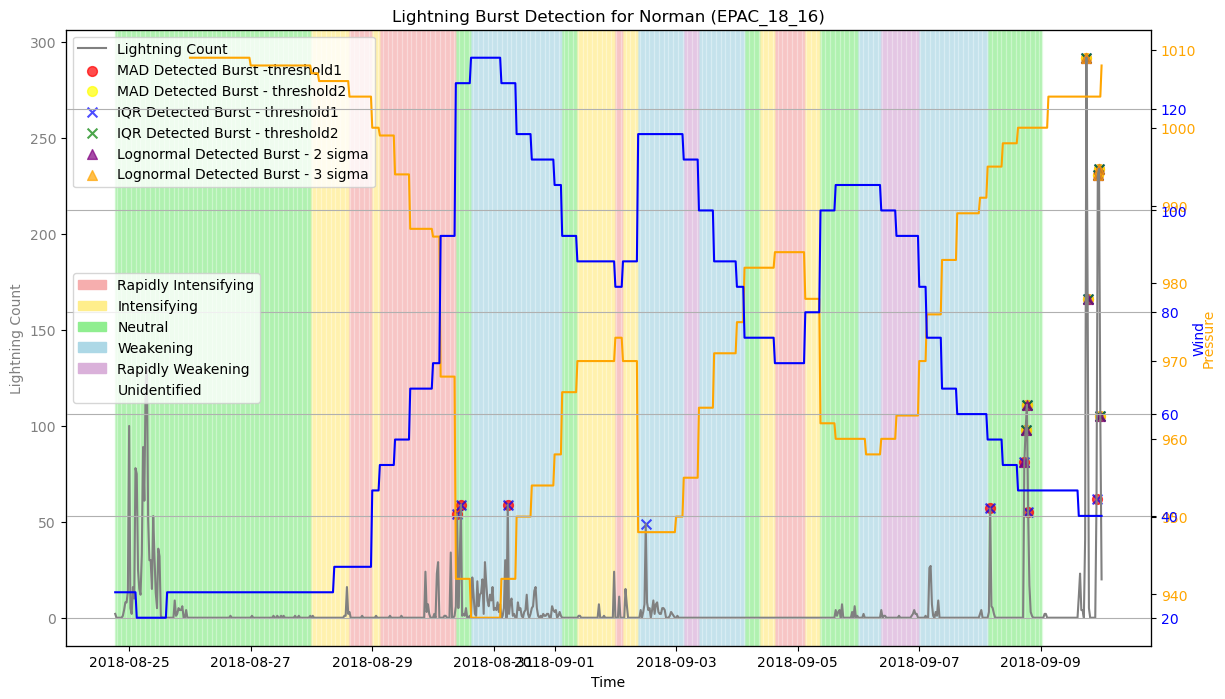

<Figure size 1000x500 with 0 Axes>

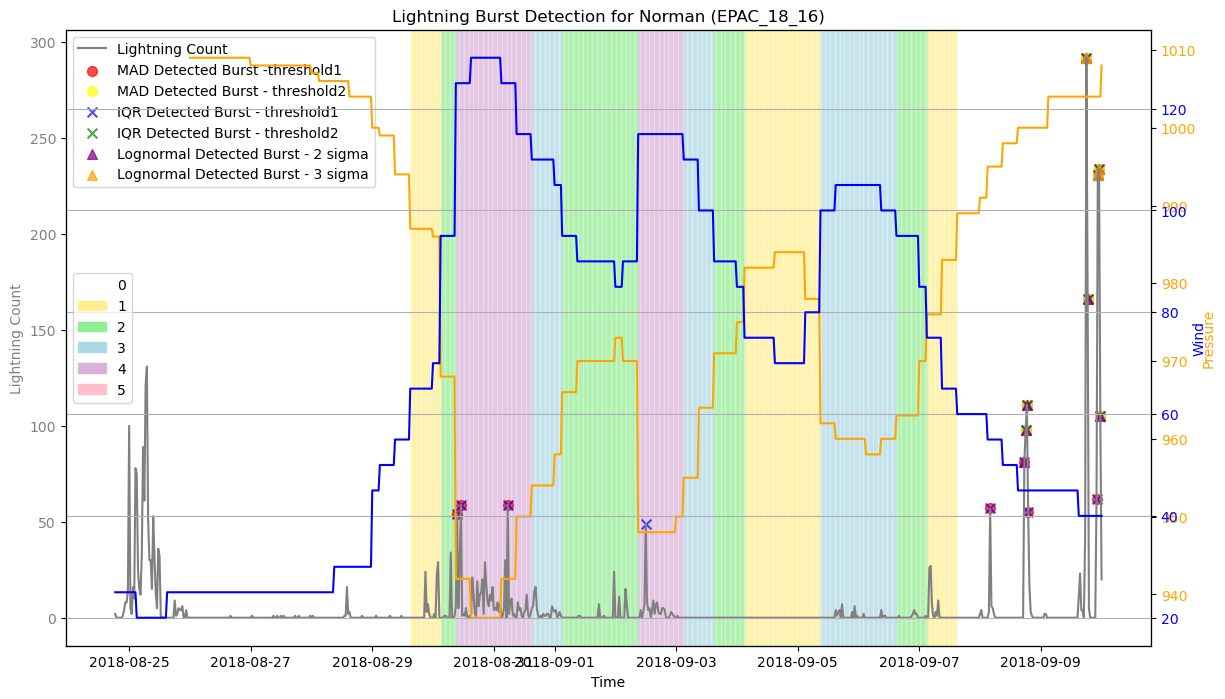

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
258,EPAC_18_16,Norman,14,7,3.960585,4.548371,15,7,3.871201,4.564348,...,3,4.218458,5.368579,170,8.24,4.12,8.82,4.12,4.71,1.76


In [37]:
# EPAC_18_16 - Norman
cyclone_id = 'EPAC_18_16'
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

<Figure size 1000x500 with 0 Axes>

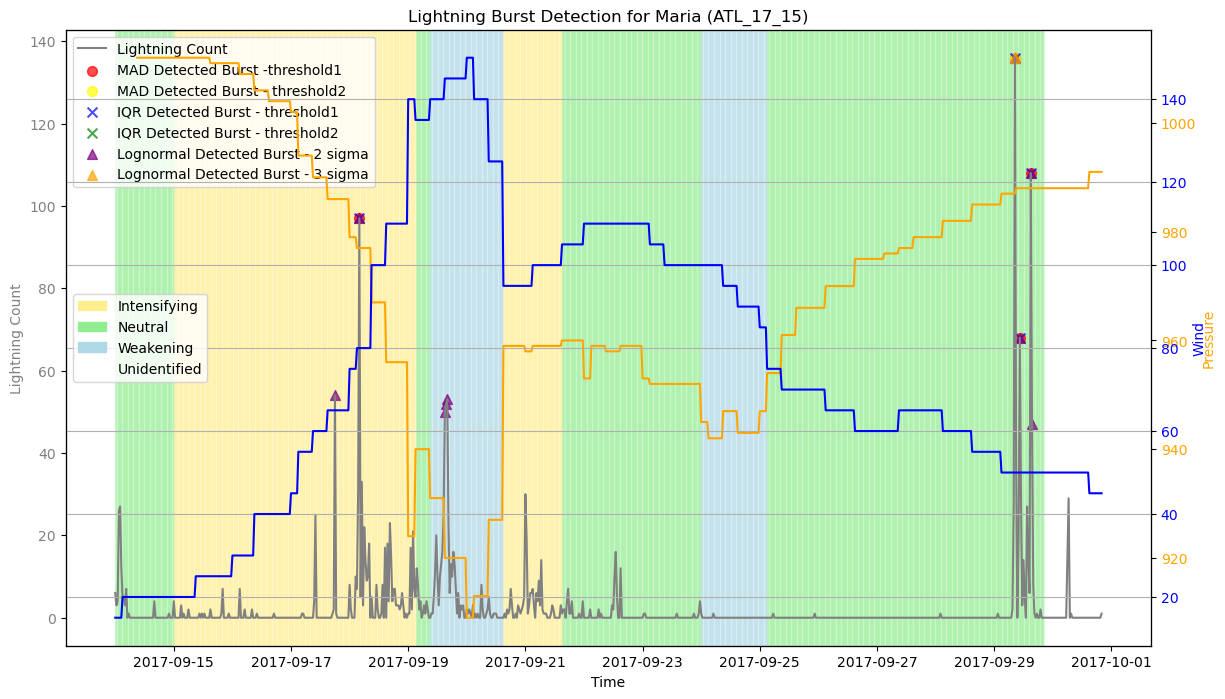

<Figure size 1000x500 with 0 Axes>

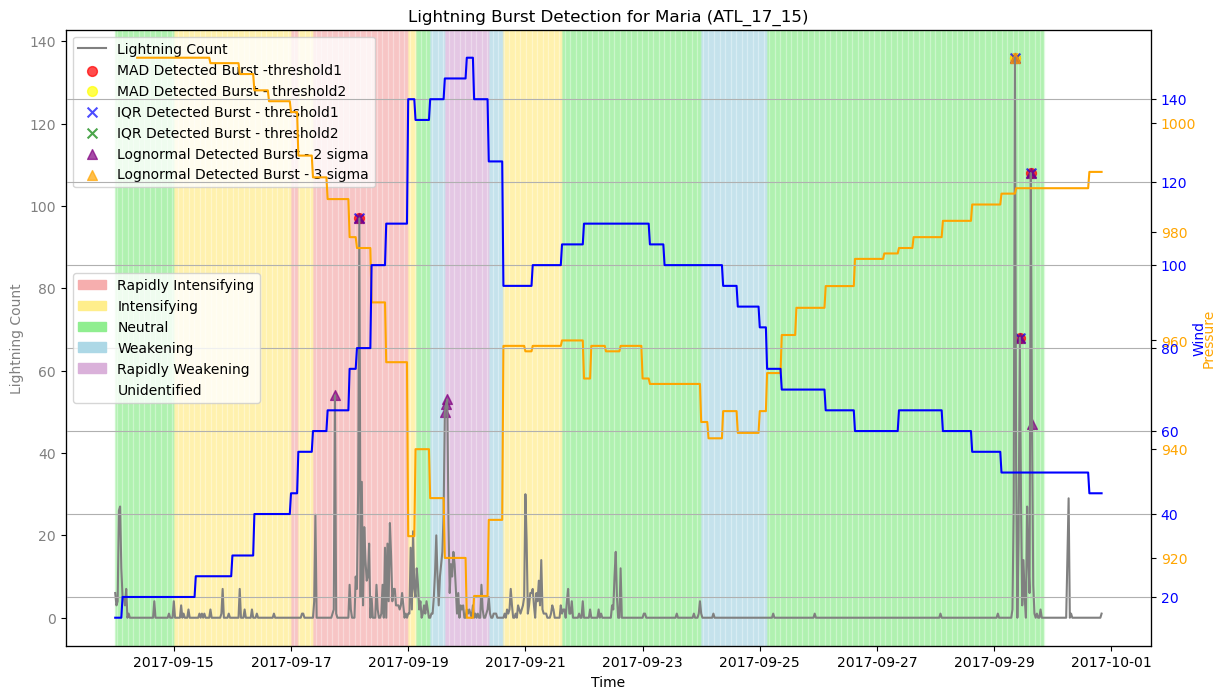

<Figure size 1000x500 with 0 Axes>

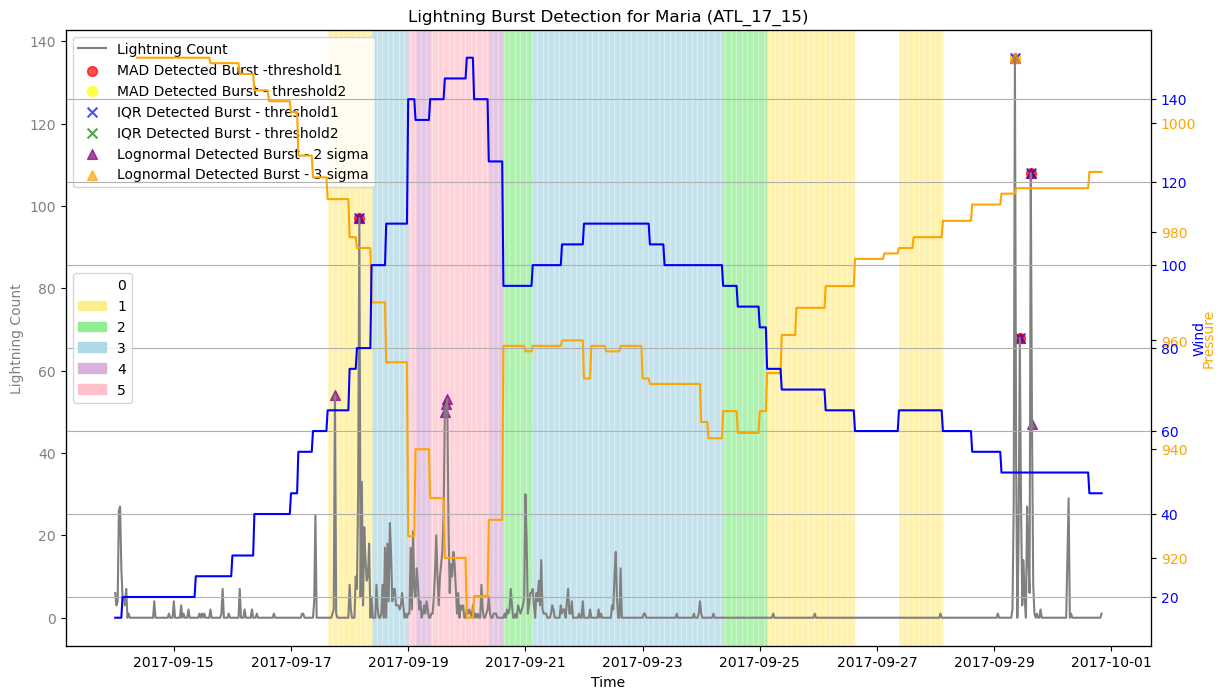

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
238,ATL_17_15,Maria,4,1,4.158883,4.85203,4,0,4.102643,4.955017,...,1,3.761648,4.773138,191,2.09,0.52,2.09,0.0,4.71,0.52


In [38]:
# ATL_17_15 - Maria
cyclone_id = 'ATL_17_15'
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

In [ ]:
# Export for external tool vis
# marker - rename files?
innercore_data.write_csv("vis_data/tc_lightning_vis_data.csv")
tc_summary.to_csv("vis_data/threshold_summary.csv")
bursts.to_csv("vis_data/tc_threshold.csv")

In [40]:
# Define threshold names for use later
threshold_names = {
    'mad1':['mad1_threshold','MAD1'],
    'mad2':['mad2_threshold','MAD2'],
    'iqr1':['iqr1_threshold','IQR1'],
    'iqr2':['iqr2_threshold','IQR2'],
    'logn1':['logn1_threshold','Lognormal 2 Sigma'],
    'logn2':['logn2_threshold','Lognormal 3 Sigma'],
}
threshold_keys = list(threshold_names.keys())
threshold_cols = [threshold_names[key][0] for key in threshold_keys]
threshold_labels = [threshold_names[key][1] for key in threshold_keys]

In [41]:
# No bursts detected
# marker - need to look into why the agg result dataframes are not the same length??
selected_columns = ["mad1_bursts", "mad2_bursts", "iqr1_bursts", "iqr2_bursts", "logn1_bursts", "logn2_bursts"]
print(f"{(tc_summary_w_0[selected_columns].sum(axis=1) == 0).sum()} TCs of {len(tc_summary_w_0)} TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.")
no_bursts = tc_summary[tc_summary[selected_columns].sum(axis=1) == 0]
print(f"{len(no_bursts)} TCs of {len(tc_summary)} TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.")

11 TCs of 472 TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.
106 TCs of 478 TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.


-------------------

### EPAC Basin
We now look at lightning burst thresholds at the basin level, starting with EPAC. We take the individual TC thresholds for TCs in the EPAC basin and create a basin-level standard separated by current category, where categories 0-2 are grouped together and categories 3-5 are grouped together.

In [42]:
# Get list of EPAC storm codes
epac_data = innercore_data.filter(pl.col("basin") == "EPAC")
epac_storm_codes = epac_data["storm_code"].unique()
epac_storm_codes.head(5)

storm_code
str
"""EPAC_10_9"""
"""EPAC_12_12"""
"""EPAC_18_16"""
"""EPAC_11_9"""
"""EPAC_15_19"""


In [43]:
# Filter aggregated table to EPAC only
epac_tc_summary = tc_summary[tc_summary["storm_code"].isin(epac_storm_codes)]
epac_tc_summary.head()

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
0,EPAC_13_8,Henriette,1,1,2.720473,3.125938,1,1,2.525729,2.983874,...,0,2.578337,3.229375,25,4.0,4.0,4.00,4.0,4.00,0.0
1,EPAC_19_15,Lorena,0,0,7.483536,8.677407,6,0,6.330050,7.510203,...,0,6.134410,7.753040,150,0.0,0.0,4.00,0.0,4.00,0.0
3,EPAC_18_15,Miriam,0,0,7.790204,9.060743,0,0,6.484027,7.702674,...,0,5.883172,7.386922,88,0.0,0.0,0.00,0.0,1.14,0.0
6,EPAC_11_5,Eugene,3,2,4.158883,4.852030,3,1,4.353224,5.268244,...,0,4.467112,5.769141,50,6.0,4.0,6.00,2.0,6.00,0.0
17,EPAC_15_9,Guillermo,0,0,5.335102,6.182399,2,0,4.446565,5.283553,...,0,4.142389,5.179236,81,0.0,0.0,2.47,0.0,4.94,0.0


In [44]:
# Filter burst point data to EPAC only
epac_bursts = bursts[bursts["storm_code"].isin(epac_storm_codes)]
epac_bursts.head()

,time_bin,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,...,iqr1_threshold,iqr2_threshold,burst_mad1,burst_mad2,mad1_threshold,mad2_threshold,burst_logn1,burst_logn2,logn1_threshold,logn2_threshold
10047,2010-06-19 18:30:00,EPAC_10_4,5,2010,6,19,18,30,12.4,-97.6,...,5.172376,6.190817,False,False,6.704246,7.89383,False,False,4.679426,5.944917
10048,2010-06-19 20:30:00,EPAC_10_4,1,2010,6,19,20,30,12.4,-97.6,...,5.172376,6.190817,False,False,6.704246,7.89383,False,False,4.679426,5.944917
10049,2010-06-20 11:30:00,EPAC_10_4,1,2010,6,20,11,30,11.8,-99.5,...,5.172376,6.190817,False,False,6.704246,7.89383,False,False,4.679426,5.944917
10050,2010-06-20 12:00:00,EPAC_10_4,7,2010,6,20,12,0,11.8,-99.5,...,5.172376,6.190817,False,False,6.704246,7.89383,False,False,4.679426,5.944917
10051,2010-06-20 12:30:00,EPAC_10_4,26,2010,6,20,12,30,11.8,-99.5,...,5.172376,6.190817,False,False,6.704246,7.89383,False,False,4.679426,5.944917


Let's look at the unweighted threshold distribution (1 occurence per TC) before splitting the timebins by current category.

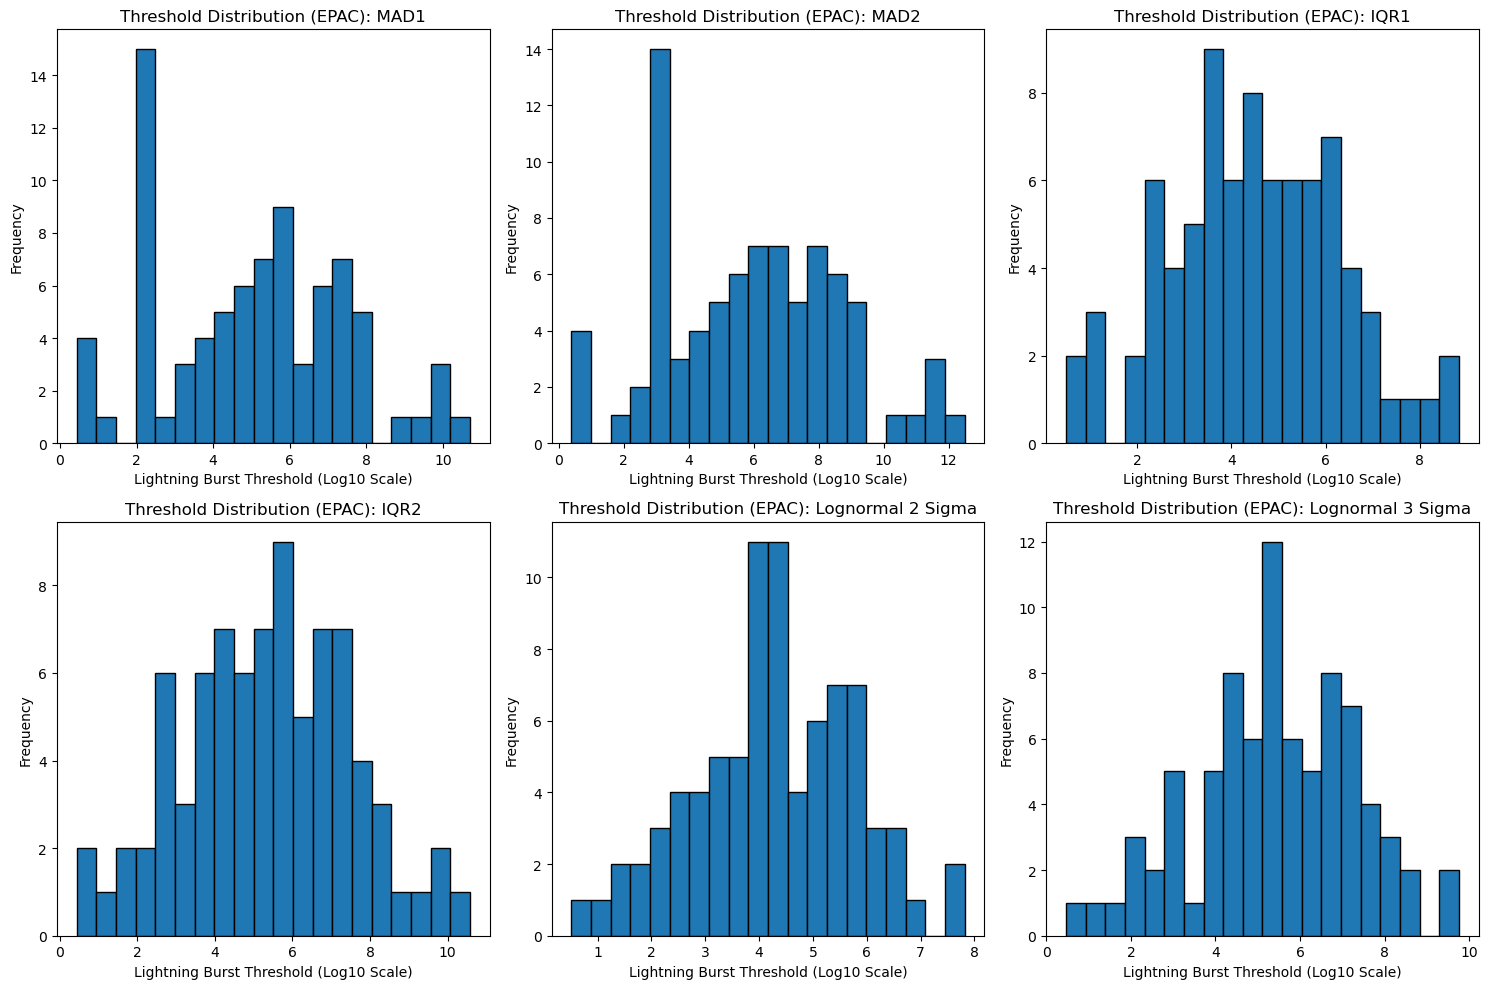

In [45]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_tc_summary, threshold, ax=axes[i])
    axes[i].set_title(f"Threshold Distribution (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

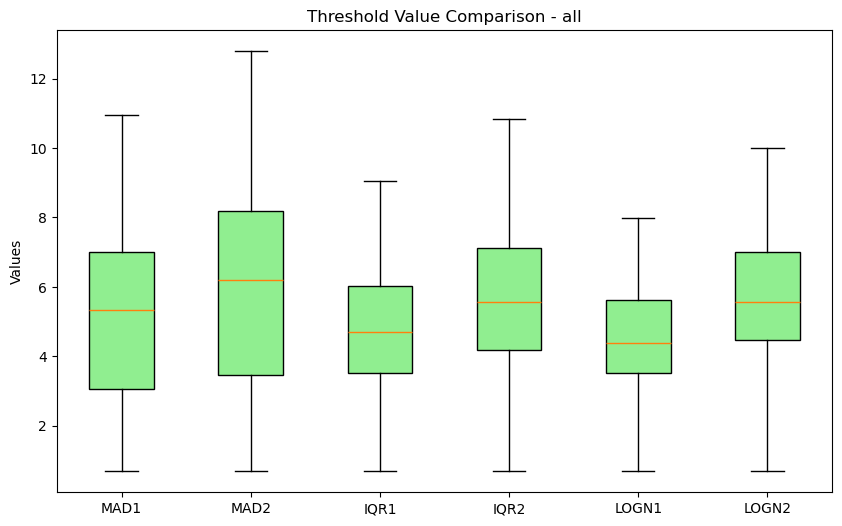

In [46]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(epac_tc_summary, "all", ax=None)

Let's explore some ideas at the basin-level:

ideas:
- most vs least vs mean/median total bursts detected? keep 6 separate?
- different categories (max speed)
- most overlap detections and least overlap detections between the 6 standards

Plotting some of the top 5 most and least bursts by threshold type:

In [47]:
selected_columns = ["mad1_bursts", "mad2_bursts", "iqr1_bursts", "iqr2_bursts", "logn1_bursts", "logn2_bursts"]
epac_no_bursts = epac_tc_summary[epac_tc_summary[selected_columns].sum(axis=1) == 0]
print(f"{len(epac_no_bursts)} TCs of {len(epac_tc_summary)} TCs with no bursts detected across all 6 threshold methods.")

23 TCs of 82 TCs with no bursts detected across all 6 threshold methods.


In [49]:
# Top 5 most MAD1 bursts (count)
epac_tc_summary.sort_values(by="mad1_bursts", ascending=False).head(5)

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
93,EPAC_15_3,Carlos,18,16,2.720473,3.125938,12,8,3.701302,4.453341,...,1,4.560759,5.986970,94,19.15,17.02,12.77,8.51,7.45,1.06
258,EPAC_18_16,Norman,14,7,3.960585,4.548371,15,7,3.871201,4.564348,...,3,4.218458,5.368579,170,8.24,4.12,8.82,4.12,4.71,1.76
429,EPAC_18_10,Hector,7,2,3.652740,4.163566,8,2,3.506558,4.108544,...,1,3.599905,4.510039,184,3.80,1.09,4.35,1.09,3.80,0.54
242,EPAC_13_5,Erick,7,5,2.720473,3.125938,4,2,3.465736,4.158883,...,0,4.205395,5.465820,29,24.14,17.24,13.79,6.90,6.90,0.00
101,EPAC_20_8,Douglas,6,6,1.706810,1.909543,1,0,2.414157,2.844409,...,0,2.379402,2.990767,34,17.65,17.65,2.94,0.00,5.88,0.00


In [50]:
# Top 5 most MAD1 bursts (prop)
epac_tc_summary.sort_values(by="mad1_prop", ascending=False).head(5)

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
100,EPAC_20_9,Elida,2,2,0.693147,0.693147,1,1,1.504077,1.706810,...,0,1.952556,2.431853,5,40.00,40.00,20.00,20.00,0.00,0.0
157,EPAC_12_7,Gilma,2,1,2.720473,3.125938,0,0,4.852030,5.891751,...,0,4.145911,5.367307,5,40.00,20.00,0.00,0.00,0.00,0.0
418,EPAC_16_4,Celia,1,1,0.693147,0.693147,1,0,1.386294,1.559581,...,0,1.724574,2.124762,3,33.33,33.33,33.33,0.00,0.00,0.0
242,EPAC_13_5,Erick,7,5,2.720473,3.125938,4,2,3.465736,4.158883,...,0,4.205395,5.465820,29,24.14,17.24,13.79,6.90,6.90,0.0
153,EPAC_16_3,Blas,5,2,2.720473,3.125938,1,1,3.198673,3.825055,...,0,3.699117,4.749321,21,23.81,9.52,4.76,4.76,4.76,0.0


In [51]:
# Bottom 5 least MAD1 bursts (count)
epac_tc_summary.sort_values(by="mad1_bursts").head(5)

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
476,EPAC_16_16,Orlene,0,0,5.769862,6.718422,0,0,4.605540,5.464292,...,0,4.222262,5.324557,6,0.0,0.0,0.00,0.0,0.00,0.0
59,EPAC_12_6,Fabio,0,0,5.101405,5.960231,0,0,4.246268,5.033182,...,0,4.203648,5.302203,28,0.0,0.0,0.00,0.0,3.57,0.0
63,EPAC_16_7,Frank,0,0,7.355006,8.485888,0,0,6.034524,7.129400,...,0,5.904155,7.421015,66,0.0,0.0,0.00,0.0,0.00,0.0
66,EPAC_14_18,Rachel,0,0,6.668218,7.612680,1,0,5.667415,6.597791,...,0,5.641386,7.022453,98,0.0,0.0,1.02,0.0,1.02,0.0
88,EPAC_15_17,Marty,0,0,10.379432,11.872610,0,0,8.684007,10.139560,...,0,7.998327,9.901105,111,0.0,0.0,0.00,0.0,0.00,0.0


In [52]:
# Top 5 most IQR1 bursts (count)
epac_tc_summary.sort_values(by="iqr1_bursts", ascending=False).head(5)

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
258,EPAC_18_16,Norman,14,7,3.960585,4.548371,15,7,3.871201,4.564348,...,3,4.218458,5.368579,170,8.24,4.12,8.82,4.12,4.71,1.76
93,EPAC_15_3,Carlos,18,16,2.720473,3.125938,12,8,3.701302,4.453341,...,1,4.560759,5.986970,94,19.15,17.02,12.77,8.51,7.45,1.06
289,EPAC_18_14,Lane,2,0,5.792262,6.677852,11,0,5.348297,6.338798,...,0,5.137852,6.456639,294,0.68,0.00,3.74,0.00,4.76,0.00
222,EPAC_15_10,Hilda,1,0,5.252624,6.079303,9,2,4.317488,5.122207,...,0,4.387132,5.545262,144,0.69,0.00,6.25,1.39,5.56,0.00
429,EPAC_18_10,Hector,7,2,3.652740,4.163566,8,2,3.506558,4.108544,...,1,3.599905,4.510039,184,3.80,1.09,4.35,1.09,3.80,0.54


In [53]:
# Top 5 most IQR1 bursts (prop)
epac_tc_summary.sort_values(by="iqr1_prop", ascending=False).head(5)

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
418,EPAC_16_4,Celia,1,1,0.693147,0.693147,1,0,1.386294,1.559581,...,0,1.724574,2.124762,3,33.33,33.33,33.33,0.00,0.00,0.0
100,EPAC_20_9,Elida,2,2,0.693147,0.693147,1,1,1.504077,1.706810,...,0,1.952556,2.431853,5,40.00,40.00,20.00,20.00,0.00,0.0
260,EPAC_14_9,Iselle,2,2,2.720473,3.125938,3,2,2.484907,2.831480,...,0,3.230223,4.075360,19,10.53,10.53,15.79,10.53,10.53,0.0
52,EPAC_11_1,Adrian,1,0,2.720473,3.125938,7,6,2.079442,2.426015,...,0,2.502932,3.150601,49,2.04,0.00,14.29,12.24,8.16,0.0
242,EPAC_13_5,Erick,7,5,2.720473,3.125938,4,2,3.465736,4.158883,...,0,4.205395,5.465820,29,24.14,17.24,13.79,6.90,6.90,0.0


In [55]:
# Bottom 5 least IQR1 bursts
epac_tc_summary.sort_values(by="iqr1_bursts").head(5)

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
59,EPAC_12_6,Fabio,0,0,5.101405,5.960231,0,0,4.246268,5.033182,...,0,4.203648,5.302203,28,0.0,0.0,0.0,0.0,3.57,0.0
63,EPAC_16_7,Frank,0,0,7.355006,8.485888,0,0,6.034524,7.129400,...,0,5.904155,7.421015,66,0.0,0.0,0.0,0.0,0.00,0.0
88,EPAC_15_17,Marty,0,0,10.379432,11.872610,0,0,8.684007,10.139560,...,0,7.998327,9.901105,111,0.0,0.0,0.0,0.0,0.00,0.0
97,EPAC_18_17,Olivia,0,0,8.255033,9.659027,0,0,6.993015,8.394695,...,0,5.686656,7.128875,53,0.0,0.0,0.0,0.0,0.00,0.0
373,EPAC_11_3,Calvin,0,0,7.639035,8.826200,0,0,6.308359,7.398971,...,0,5.590864,6.955645,29,0.0,0.0,0.0,0.0,0.00,0.0


In [56]:
# Top 5 most LOGN two sigma bursts (count)
epac_tc_summary.sort_values(by="logn1_bursts", ascending=False).head(5)

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
289,EPAC_18_14,Lane,2,0,5.792262,6.677852,11,0,5.348297,6.338798,...,0,5.137852,6.456639,294,0.68,0.00,3.74,0.00,4.76,0.00
222,EPAC_15_10,Hilda,1,0,5.252624,6.079303,9,2,4.317488,5.122207,...,0,4.387132,5.545262,144,0.69,0.00,6.25,1.39,5.56,0.00
258,EPAC_18_16,Norman,14,7,3.960585,4.548371,15,7,3.871201,4.564348,...,3,4.218458,5.368579,170,8.24,4.12,8.82,4.12,4.71,1.76
429,EPAC_18_10,Hector,7,2,3.652740,4.163566,8,2,3.506558,4.108544,...,1,3.599905,4.510039,184,3.80,1.09,4.35,1.09,3.80,0.54
93,EPAC_15_3,Carlos,18,16,2.720473,3.125938,12,8,3.701302,4.453341,...,1,4.560759,5.986970,94,19.15,17.02,12.77,8.51,7.45,1.06


In [57]:
# Top 5 most LOGN two sigma bursts (prop)
epac_tc_summary.sort_values(by="logn1_prop", ascending=False).head(5)

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
187,EPAC_19_11,Juliette,2,1,3.439678,3.988984,2,2,2.890372,3.439678,...,0,3.682064,4.744758,18,11.11,5.56,11.11,11.11,11.11,0.00
260,EPAC_14_9,Iselle,2,2,2.720473,3.125938,3,2,2.484907,2.831480,...,0,3.230223,4.075360,19,10.53,10.53,15.79,10.53,10.53,0.00
52,EPAC_11_1,Adrian,1,0,2.720473,3.125938,7,6,2.079442,2.426015,...,0,2.502932,3.150601,49,2.04,0.00,14.29,12.24,8.16,0.00
224,EPAC_12_4,Daniel,1,1,2.720473,3.125938,1,0,3.701302,4.453341,...,0,3.469091,4.443309,13,7.69,7.69,7.69,0.00,7.69,0.00
93,EPAC_15_3,Carlos,18,16,2.720473,3.125938,12,8,3.701302,4.453341,...,1,4.560759,5.986970,94,19.15,17.02,12.77,8.51,7.45,1.06


In [58]:
# Bottom 5 least LOGN 2 sigma bursts - these all don't have any bursts across all 6
epac_tc_summary.sort_values(by="logn1_bursts").head(5)

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
63,EPAC_16_7,Frank,0,0,7.355006,8.485888,0,0,6.034524,7.129400,...,0,5.904155,7.421015,66,0.0,0.0,0.0,0.0,0.0,0.0
347,EPAC_12_3,Carlotta,0,0,9.771618,11.506219,0,0,7.049255,8.638282,...,0,6.446706,8.262073,41,0.0,0.0,0.0,0.0,0.0,0.0
97,EPAC_18_17,Olivia,0,0,8.255033,9.659027,0,0,6.993015,8.394695,...,0,5.686656,7.128875,53,0.0,0.0,0.0,0.0,0.0,0.0
88,EPAC_15_17,Marty,0,0,10.379432,11.872610,0,0,8.684007,10.139560,...,0,7.998327,9.901105,111,0.0,0.0,0.0,0.0,0.0,0.0
100,EPAC_20_9,Elida,2,2,0.693147,0.693147,1,1,1.504077,1.706810,...,0,1.952556,2.431853,5,40.0,40.0,20.0,20.0,0.0,0.0


look at categories

look at threshold overlap - how to quantify?

We then create a summary for the weaker categories and create an initial basin-category threshold defined as 2 standard deviations + the mean or median.

In [59]:
# Group the data into weak and strong category datasets using function
# Note that this is grouping only the data used in the analysis (excluding less than 40 knots)
epac_weak0_lightning, epac_weak1_lightning, epac_strong_lightning = group_bins_category(epac_bursts)

3850 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
1561 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
1398 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


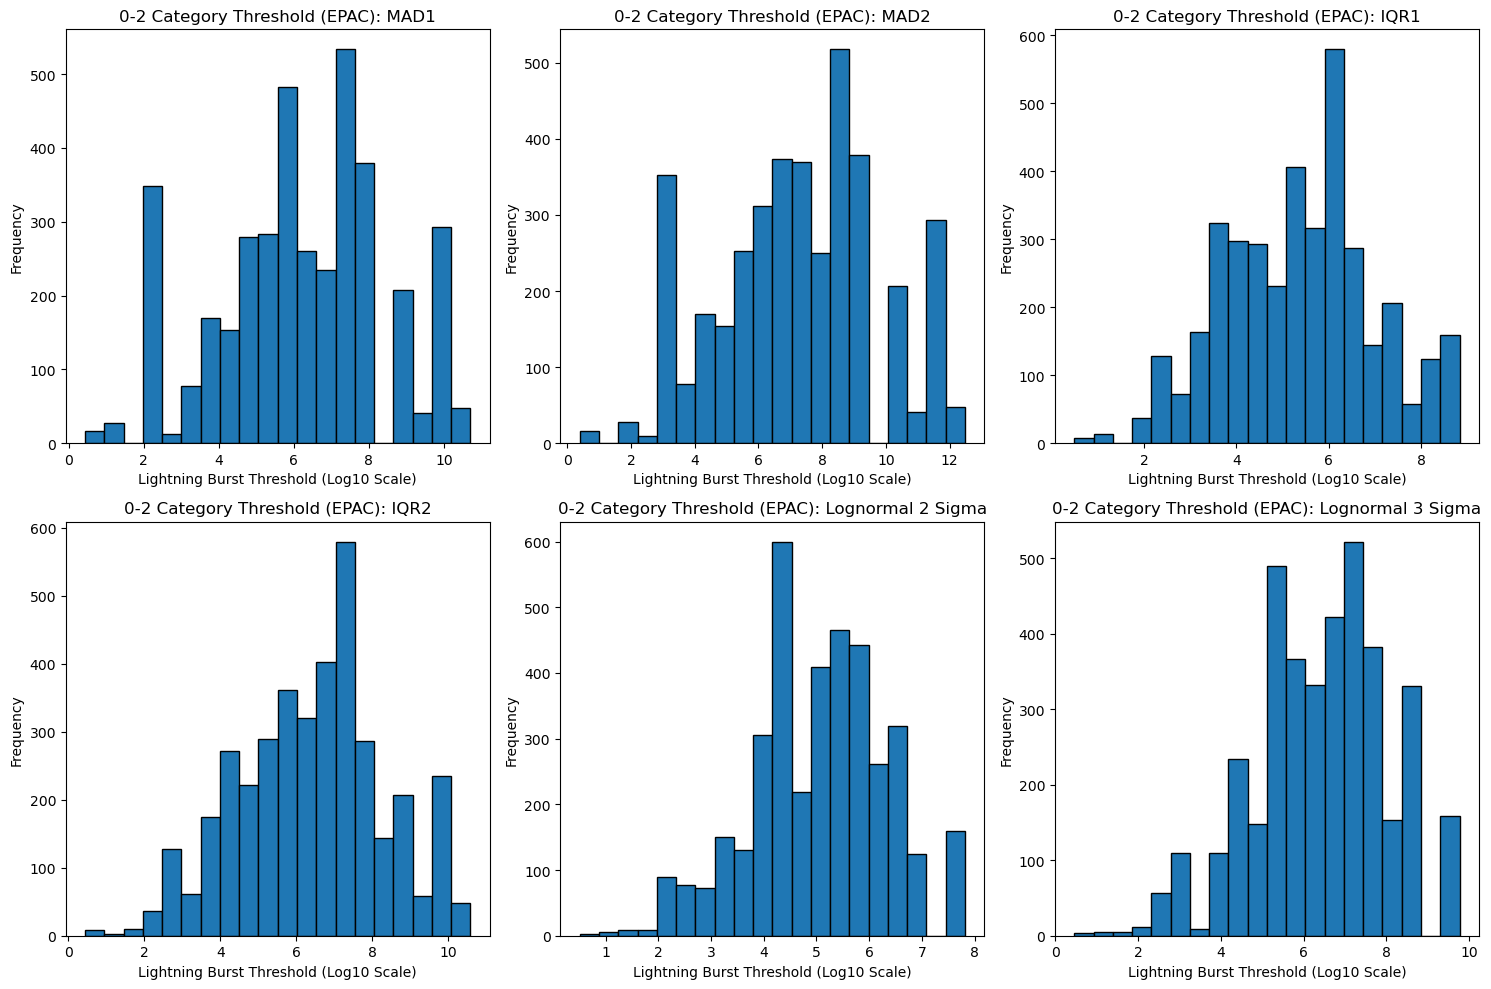

In [72]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_weak0_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

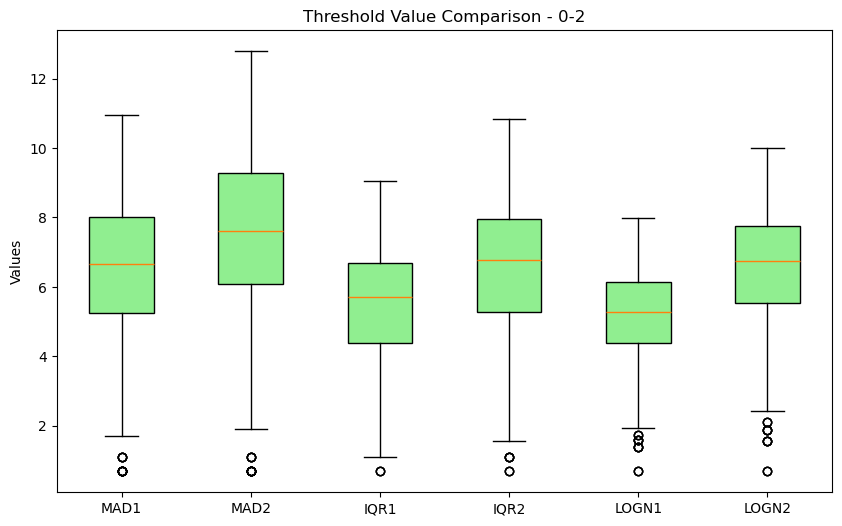

In [71]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(epac_weak0_lightning, "0-2", ax=None)

In [70]:
# Get mean and 2 standard dev - 0-2 categories
epac_weak0_summary = create_basin_summary(epac_weak0_lightning, "0-2", "EPAC")
epac_weak0_summary

,Basin,Category Group,Threshold,Mean,Std Dev,Median,Min,Max,Basin-Category Threshold (Mean-Based),Basin-Category Threshold (Median-Based),Burst Count,Timebin Count,Burst Percentage
0,EPAC,0-2,mad1,6.527584,2.173121,6.668218,0.693147,10.962409,10.873827,11.014461,82,3850,2.13
1,EPAC,0-2,mad2,7.576961,2.544147,7.612680,0.693147,12.785568,12.665256,12.700975,52,3850,1.35
2,EPAC,0-2,iqr1,5.592081,1.602030,5.703782,0.693147,9.045240,8.796140,8.907842,119,3850,3.09
3,EPAC,0-2,iqr2,6.660095,1.929695,6.775983,0.693147,10.829707,10.519485,10.635373,40,3850,1.04
4,EPAC,0-2,logn1,5.233589,1.270183,5.285497,0.693147,7.998327,7.773955,7.825864,141,3850,3.66
5,EPAC,0-2,logn2,6.606666,1.598939,6.761672,0.693147,9.996606,9.804544,9.959551,6,3850,0.16


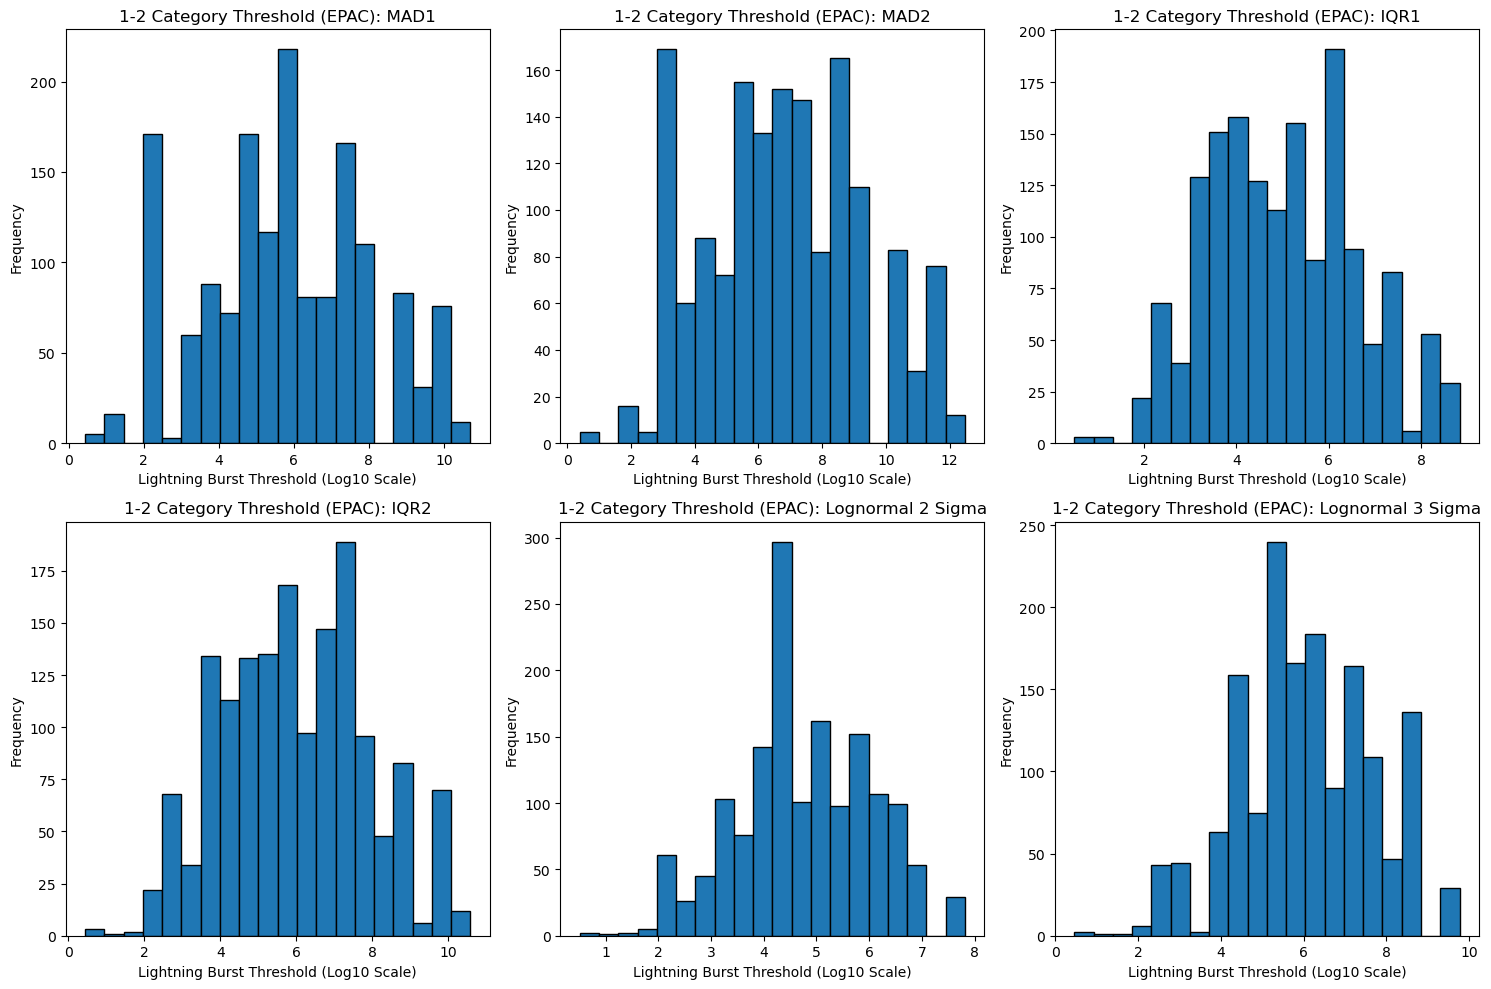

In [64]:
# Plot threshold value distributions for 1-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_weak1_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"1-2 Category Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

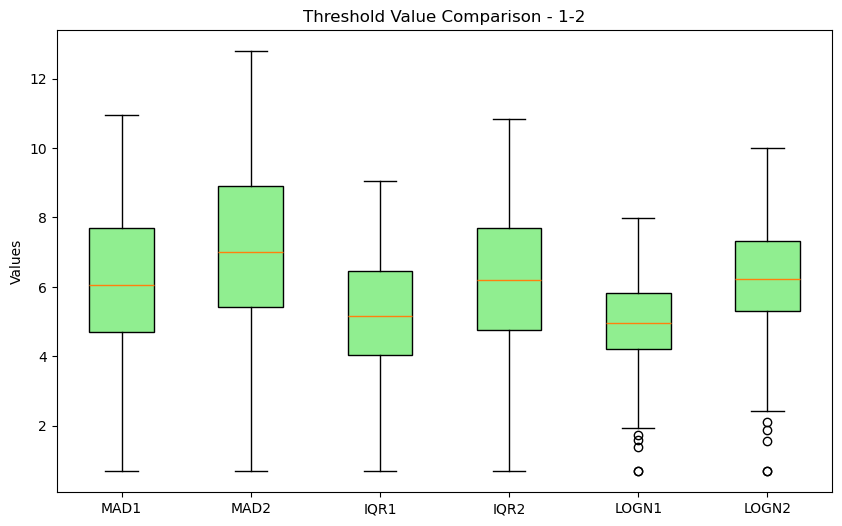

In [65]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(epac_weak1_lightning, "1-2", ax=None)

In [73]:
# Get mean and 2 standard dev - 1-2 categories
epac_weak1_summary = create_basin_summary(epac_weak1_lightning, "1-2", "EPAC")
epac_weak1_summary

,Basin,Category Group,Threshold,Mean,Std Dev,Median,Min,Max,Basin-Category Threshold (Mean-Based),Basin-Category Threshold (Median-Based),Burst Count,Timebin Count,Burst Percentage
0,EPAC,1-2,mad1,6.119381,2.165851,6.063117,0.693147,10.962409,10.451083,10.394819,34,1561,2.18
1,EPAC,1-2,mad2,7.104991,2.543813,7.004327,0.693147,12.785568,12.192618,12.091953,25,1561,1.60
2,EPAC,1-2,iqr1,5.246400,1.588451,5.172376,0.693147,9.045240,8.423303,8.349279,42,1561,2.69
3,EPAC,1-2,iqr2,6.251145,1.922062,6.190817,0.693147,10.829707,10.095269,10.034941,15,1561,0.96
4,EPAC,1-2,logn1,4.931581,1.255843,4.967780,0.693147,7.998327,7.443267,7.479467,51,1561,3.27
5,EPAC,1-2,logn2,6.227157,1.591641,6.221871,0.693147,9.996606,9.410440,9.405154,2,1561,0.13


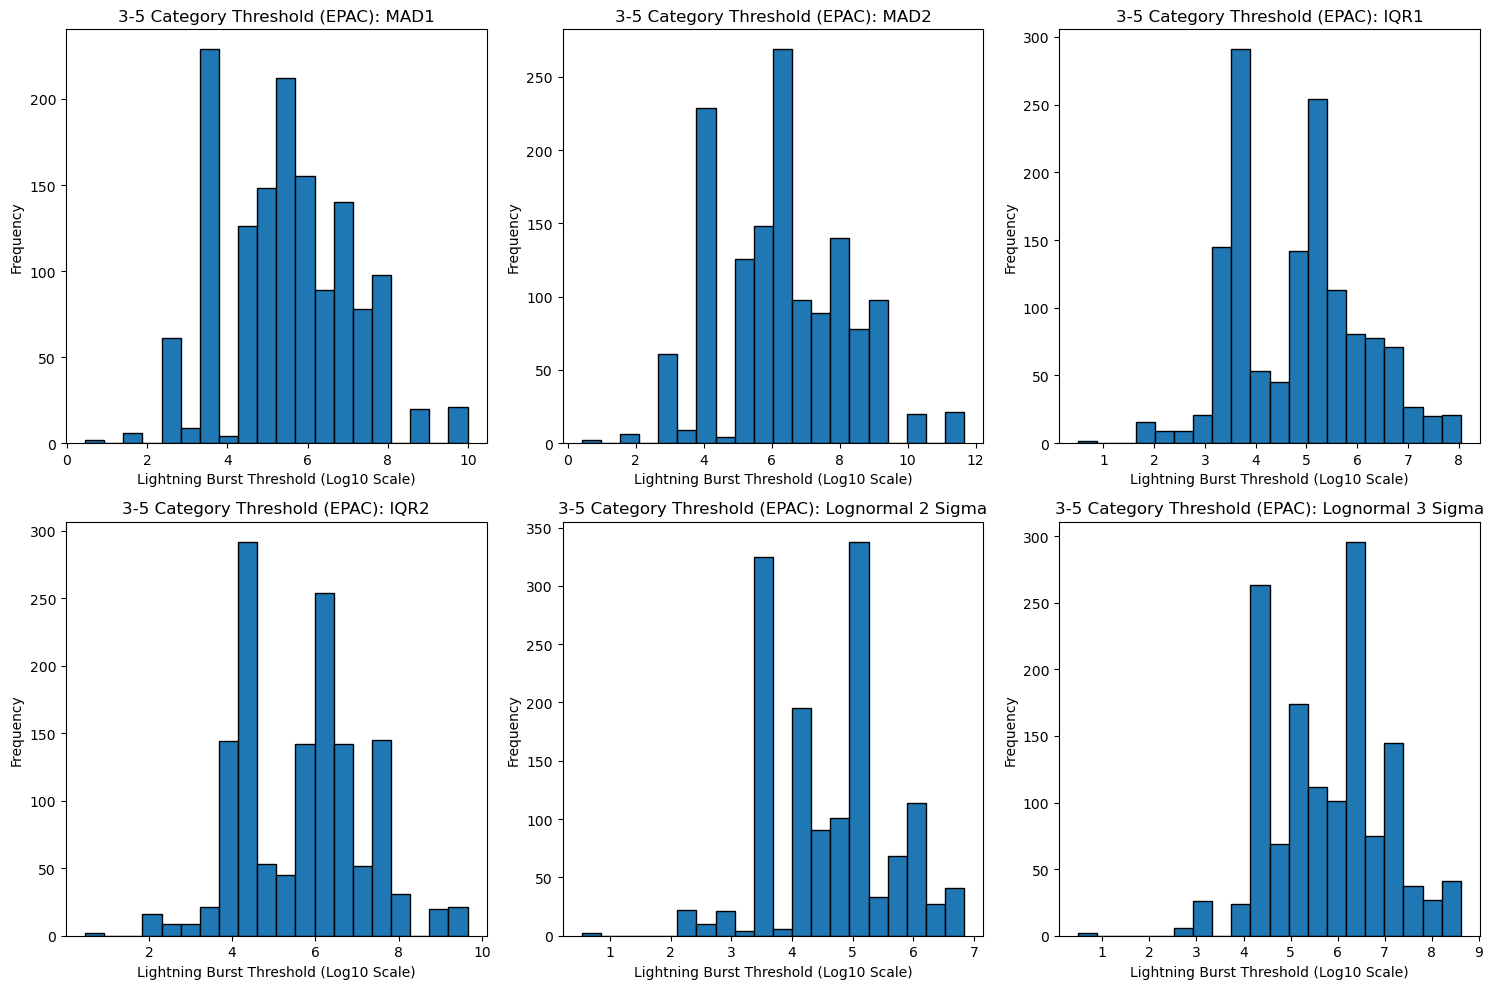

In [67]:
# Plot threshold value distributions for 3-5 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_strong_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"3-5 Category Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

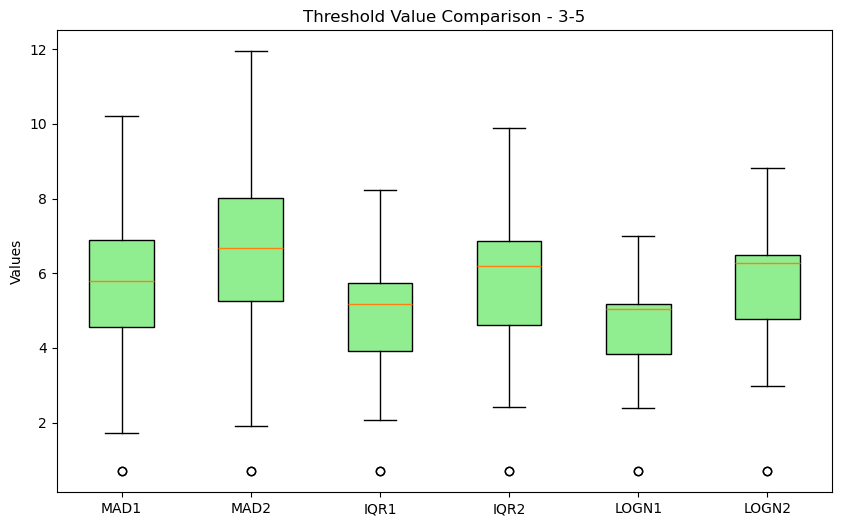

In [68]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(epac_strong_lightning, "3-5", ax=None)

In [74]:
# Get mean and 2 standard dev - 3-5 categories
epac_strong_summary = create_basin_summary(epac_strong_lightning, "3-5", "EPAC")
epac_strong_summary

,Basin,Category Group,Threshold,Mean,Std Dev,Median,Min,Max,Basin-Category Threshold (Mean-Based),Basin-Category Threshold (Median-Based),Burst Count,Timebin Count,Burst Percentage
0,EPAC,3-5,mad1,5.719598,1.635318,5.792262,0.693147,10.223271,8.990233,9.062898,11,1398,0.79
1,EPAC,3-5,mad2,6.603652,1.907559,6.677852,0.693147,11.946037,10.418769,10.492969,1,1398,0.07
2,EPAC,3-5,iqr1,4.990127,1.245536,5.172376,0.693147,8.230524,7.481199,7.663448,13,1398,0.93
3,EPAC,3-5,iqr2,5.898325,1.480719,6.190817,0.693147,9.885795,8.859763,9.152255,0,1398,0.00
4,EPAC,3-5,logn1,4.755955,0.985998,5.033171,0.693147,6.999298,6.727951,7.005167,16,1398,1.14
5,EPAC,3-5,logn2,5.963515,1.226997,6.285003,0.693147,8.822181,8.417509,8.738997,0,1398,0.00


Apply the basin-category thresholds (mean and median based) to the basin by weak/strong category groupings. 

In [76]:
epac_weak0_summary, epac_weak0_bursts_mean, epac_weak0_summary_mean, epac_weak0_bursts_median, epac_weak0_summary_median = summarize_threshold_eval(epac_weak0_summary, epac_weak0_lightning)
epac_weak0_summary

,Basin,Category Group,Threshold,Mean,Std Dev,Median,Min,Max,Basin-Category Threshold (Mean-Based),Basin-Category Threshold (Median-Based),Burst Count,Timebin Count,Burst Percentage,Mean-Based Threshold Bursts,Mean-Based Threshold Burst Percentage,Median-Based Threshold Bursts,Median-Based Threshold Burst Percentage
0,EPAC,0-2,mad1,6.527584,2.173121,6.668218,0.693147,10.962409,10.873827,11.014461,82,3850,2.13,0,0.0,0,0.0
1,EPAC,0-2,mad2,7.576961,2.544147,7.612680,0.693147,12.785568,12.665256,12.700975,52,3850,1.35,0,0.0,0,0.0
2,EPAC,0-2,iqr1,5.592081,1.602030,5.703782,0.693147,9.045240,8.796140,8.907842,119,3850,3.09,0,0.0,0,0.0
3,EPAC,0-2,iqr2,6.660095,1.929695,6.775983,0.693147,10.829707,10.519485,10.635373,40,3850,1.04,0,0.0,0,0.0
4,EPAC,0-2,logn1,5.233589,1.270183,5.285497,0.693147,7.998327,7.773955,7.825864,141,3850,3.66,0,0.0,0,0.0
5,EPAC,0-2,logn2,6.606666,1.598939,6.761672,0.693147,9.996606,9.804544,9.959551,6,3850,0.16,0,0.0,0,0.0


We see that these basin-category thresholds are very high and end up flagging 0 timebins as bursts. Let's do the same for the stronger categories.

In [77]:
epac_weak1_summary, epac_weak1_bursts_mean, epac_weak1_summary_mean, epac_weak1_bursts_median, epac_weak1_summary_median = summarize_threshold_eval(epac_weak1_summary, epac_weak1_lightning)
epac_weak1_summary

,Basin,Category Group,Threshold,Mean,Std Dev,Median,Min,Max,Basin-Category Threshold (Mean-Based),Basin-Category Threshold (Median-Based),Burst Count,Timebin Count,Burst Percentage,Mean-Based Threshold Bursts,Mean-Based Threshold Burst Percentage,Median-Based Threshold Bursts,Median-Based Threshold Burst Percentage
0,EPAC,1-2,mad1,6.119381,2.165851,6.063117,0.693147,10.962409,10.451083,10.394819,34,1561,2.18,0,0.0,0,0.0
1,EPAC,1-2,mad2,7.104991,2.543813,7.004327,0.693147,12.785568,12.192618,12.091953,25,1561,1.60,0,0.0,0,0.0
2,EPAC,1-2,iqr1,5.246400,1.588451,5.172376,0.693147,9.045240,8.423303,8.349279,42,1561,2.69,0,0.0,0,0.0
3,EPAC,1-2,iqr2,6.251145,1.922062,6.190817,0.693147,10.829707,10.095269,10.034941,15,1561,0.96,0,0.0,0,0.0
4,EPAC,1-2,logn1,4.931581,1.255843,4.967780,0.693147,7.998327,7.443267,7.479467,51,1561,3.27,0,0.0,0,0.0
5,EPAC,1-2,logn2,6.227157,1.591641,6.221871,0.693147,9.996606,9.410440,9.405154,2,1561,0.13,0,0.0,0,0.0


Let's do the same for the 3-5 category group.

In [78]:
epac_strong_summary, epac_strong_bursts_mean, epac_strong_summary_mean, epac_strong_bursts_median,  epac_strong_summary_median = summarize_threshold_eval(epac_strong_summary, epac_strong_lightning)
epac_strong_summary

,Basin,Category Group,Threshold,Mean,Std Dev,Median,Min,Max,Basin-Category Threshold (Mean-Based),Basin-Category Threshold (Median-Based),Burst Count,Timebin Count,Burst Percentage,Mean-Based Threshold Bursts,Mean-Based Threshold Burst Percentage,Median-Based Threshold Bursts,Median-Based Threshold Burst Percentage
0,EPAC,3-5,mad1,5.719598,1.635318,5.792262,0.693147,10.223271,8.990233,9.062898,11,1398,0.79,0,0.0,0,0.0
1,EPAC,3-5,mad2,6.603652,1.907559,6.677852,0.693147,11.946037,10.418769,10.492969,1,1398,0.07,0,0.0,0,0.0
2,EPAC,3-5,iqr1,4.990127,1.245536,5.172376,0.693147,8.230524,7.481199,7.663448,13,1398,0.93,0,0.0,0,0.0
3,EPAC,3-5,iqr2,5.898325,1.480719,6.190817,0.693147,9.885795,8.859763,9.152255,0,1398,0.00,0,0.0,0,0.0
4,EPAC,3-5,logn1,4.755955,0.985998,5.033171,0.693147,6.999298,6.727951,7.005167,16,1398,1.14,0,0.0,0,0.0
5,EPAC,3-5,logn2,5.963515,1.226997,6.285003,0.693147,8.822181,8.417509,8.738997,0,1398,0.00,0,0.0,0,0.0


Once again, we see no bursts using the basin-category thresholds (2 standard deviations from mean/median).

Let's look at the distribution of "effective" thresholds - ones where at least one timebin was flagged as a burst.

In [85]:
burst_columns = ['burst_iqr1', 'burst_iqr2', 'burst_mad1', 'burst_mad2', 'burst_logn1', 'burst_logn2']
# Filter data to only those with at least one "True" value in the burst columns, grouped by storm code
# Do not include thresholds that don't flag a burst
mask = epac_bursts.groupby("storm_code")[burst_columns].transform(lambda group: group.any(axis=0))

# Filter rows to where at least one burst col has True value
epac_bursts_effective = epac_bursts[epac_bursts[burst_columns].any(axis=1)].copy()

# Set threshold values to NaN where burst columns are False
for burst_col, threshold_col in zip(burst_columns, threshold_cols):
    epac_bursts_effective[threshold_col] = epac_bursts_effective[threshold_col].where(epac_bursts_effective[burst_col], np.nan)

epac_storm_codes_effective = epac_bursts_effective["storm_code"].unique()
epac_tc_summary_effective = epac_tc_summary[epac_tc_summary["storm_code"].isin(epac_storm_codes_effective)]

epac_bursts_effective.head()

,time_bin,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,...,iqr1_threshold,iqr2_threshold,burst_mad1,burst_mad2,mad1_threshold,mad2_threshold,burst_logn1,burst_logn2,logn1_threshold,logn2_threshold
10077,2010-06-22 07:30:00,EPAC_10_4,122,2010,6,22,7,30,11.6,-104.3,...,NaN,NaN,False,False,NaN,NaN,True,False,4.679426,NaN
10097,2010-06-24 07:30:00,EPAC_10_4,135,2010,6,24,7,30,12.3,-112.2,...,NaN,NaN,False,False,NaN,NaN,True,False,4.679426,NaN
10148,2010-08-24 03:00:00,EPAC_10_9,136,2010,8,24,3,0,15.2,-100.5,...,NaN,NaN,False,False,6.063117,NaN,True,False,4.643800,NaN
10155,2010-08-24 12:30:00,EPAC_10_9,138,2010,8,24,12,30,15.4,-101.1,...,NaN,NaN,False,False,6.063117,NaN,True,False,4.643800,NaN
10192,2010-08-25 14:30:00,EPAC_10_9,194,2010,8,25,14,30,16.5,-104.6,...,NaN,NaN,False,False,6.063117,NaN,True,False,4.643800,NaN


In [83]:
print(f"{len(epac_storm_codes_effective)} TCs of {len(epac_storm_codes)} EPAC TCs after filtering for bursts of any type")

59 TCs of 82 EPAC TCs after filtering for bursts of any type


In [84]:
epac_effective_summary = create_basin_summary(epac_bursts_effective, "all", "EPAC")
epac_effective_summary

,Basin,Category Group,Threshold,Mean,Std Dev,Median,Min,Max,Basin-Category Threshold (Mean-Based),Basin-Category Threshold (Median-Based),Burst Count,Timebin Count,Burst Percentage
0,EPAC,all,mad1,4.570221,1.662344,4.270455,0.693147,8.258979,7.894910,7.595143,93,204,45.59
1,EPAC,all,mad2,3.907350,1.387424,3.125938,0.693147,8.132119,6.682197,5.900785,53,204,25.98
2,EPAC,all,iqr1,3.643620,0.960844,3.701302,1.386294,6.191953,5.565309,5.622991,132,204,64.71
3,EPAC,all,iqr2,3.946447,0.905727,4.453341,1.559581,5.891751,5.757900,6.264794,40,204,19.61
4,EPAC,all,logn1,4.624058,1.029793,4.560759,2.343750,6.767766,6.683645,6.620345,157,204,76.96
5,EPAC,all,logn2,5.006578,0.901697,5.368579,3.436726,5.986970,6.809973,7.171973,6,204,2.94


In this context, the burst percentage represents how much of the total number of flagged bursts (across all threshold types) the particular threshold type flagged. For example, 204 timebins means there are 204 total bursts across all TCs in the EPAC basin and across all 6 threshold types. Of these, 64.71% were flagged by the MAD method, specifically the first threshold value (the lower one). It can be noted that the burst percentages do not add up to 100% due to the fact that multiple thresholds will flag the same burst.

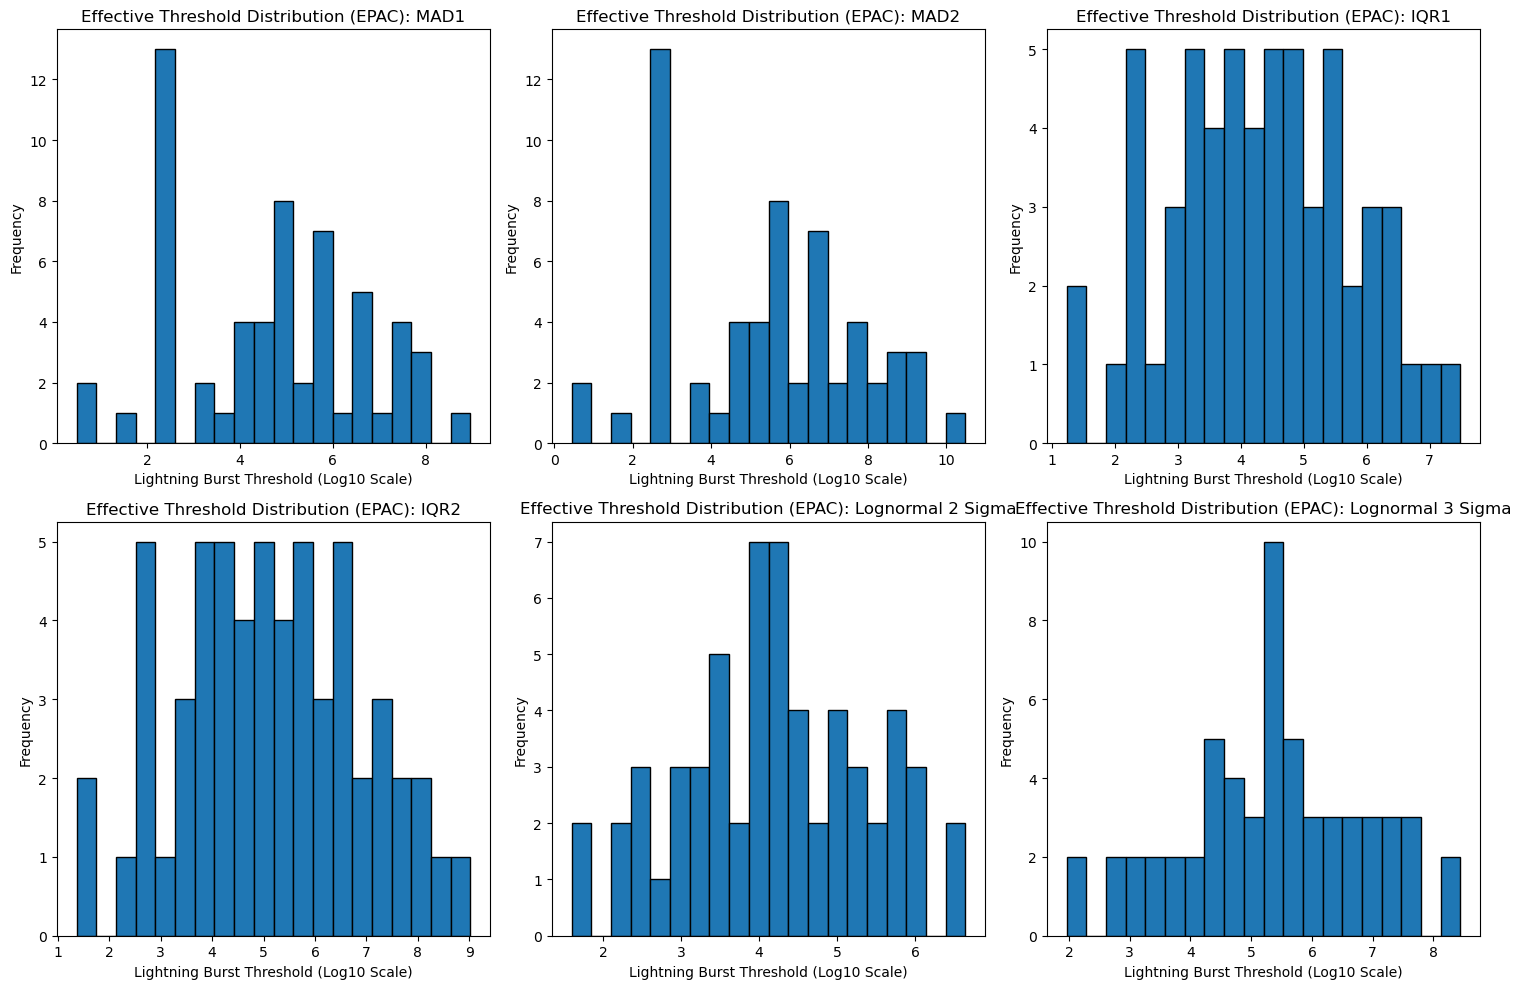

In [86]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_tc_summary_effective, threshold, ax=axes[i])
    axes[i].set_title(f"Effective Threshold Distribution (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [87]:
# Group the data into weak and strong category datasets using function
epac_weak0_effective_lightning, epac_weak1_effective_lightning, epac_strong_effective_lightning = group_bins_category(epac_bursts_effective)

181 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
68 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
23 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


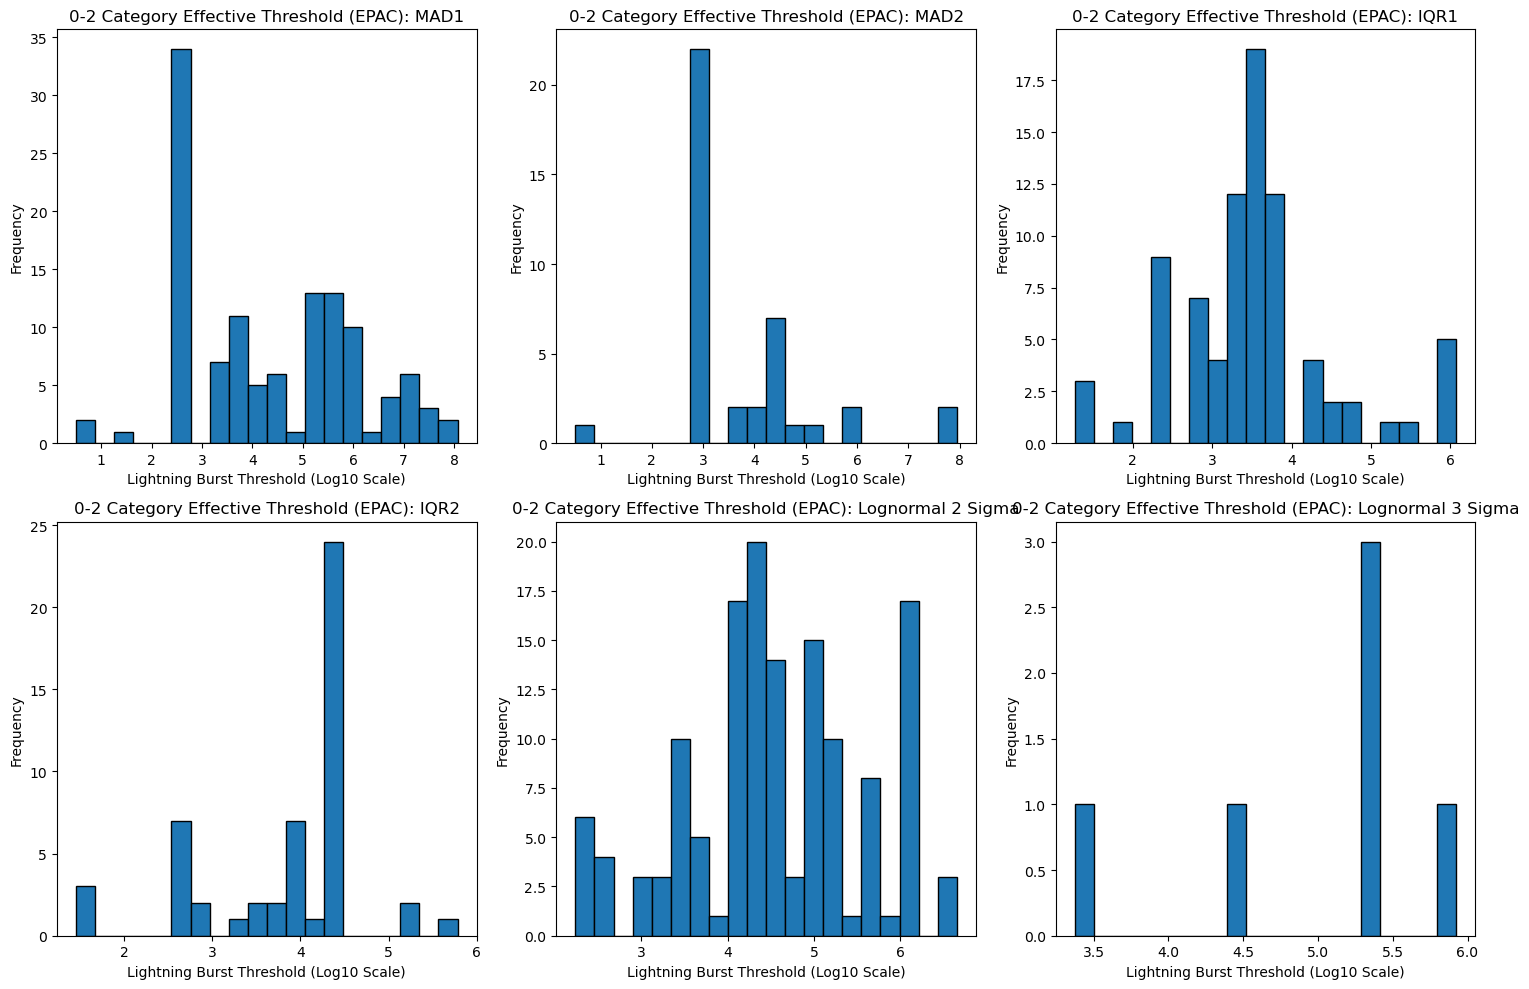

In [88]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_weak0_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Effective Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [90]:
# Get mean and 2 standard dev - 0-2 categories
epac_weak0_effective_summary = create_basin_summary(epac_weak0_effective_lightning, "0-2", "EPAC")
epac_weak0_effective_summary

,Basin,Category Group,Threshold,Mean,Std Dev,Median,Min,Max,Basin-Category Threshold (Mean-Based),Basin-Category Threshold (Median-Based),Burst Count,Timebin Count,Burst Percentage
0,EPAC,0-2,mad1,4.557847,1.722731,4.382027,0.693147,8.258979,8.003309,7.827488,82,181,45.30
1,EPAC,0-2,mad2,3.907350,1.387424,3.125938,0.693147,8.132119,6.682197,5.900785,52,181,28.73
2,EPAC,0-2,iqr1,3.642842,0.994310,3.701302,1.386294,6.191953,5.631462,5.689922,119,181,65.75
3,EPAC,0-2,iqr2,3.967640,0.901196,4.453341,1.559581,5.891751,5.770032,6.255733,40,181,22.10
4,EPAC,0-2,logn1,4.649019,1.041497,4.560759,2.343750,6.767766,6.732013,6.643753,141,181,77.90
5,EPAC,0-2,logn2,5.006578,0.901697,5.368579,3.436726,5.986970,6.809973,7.171973,6,181,3.31


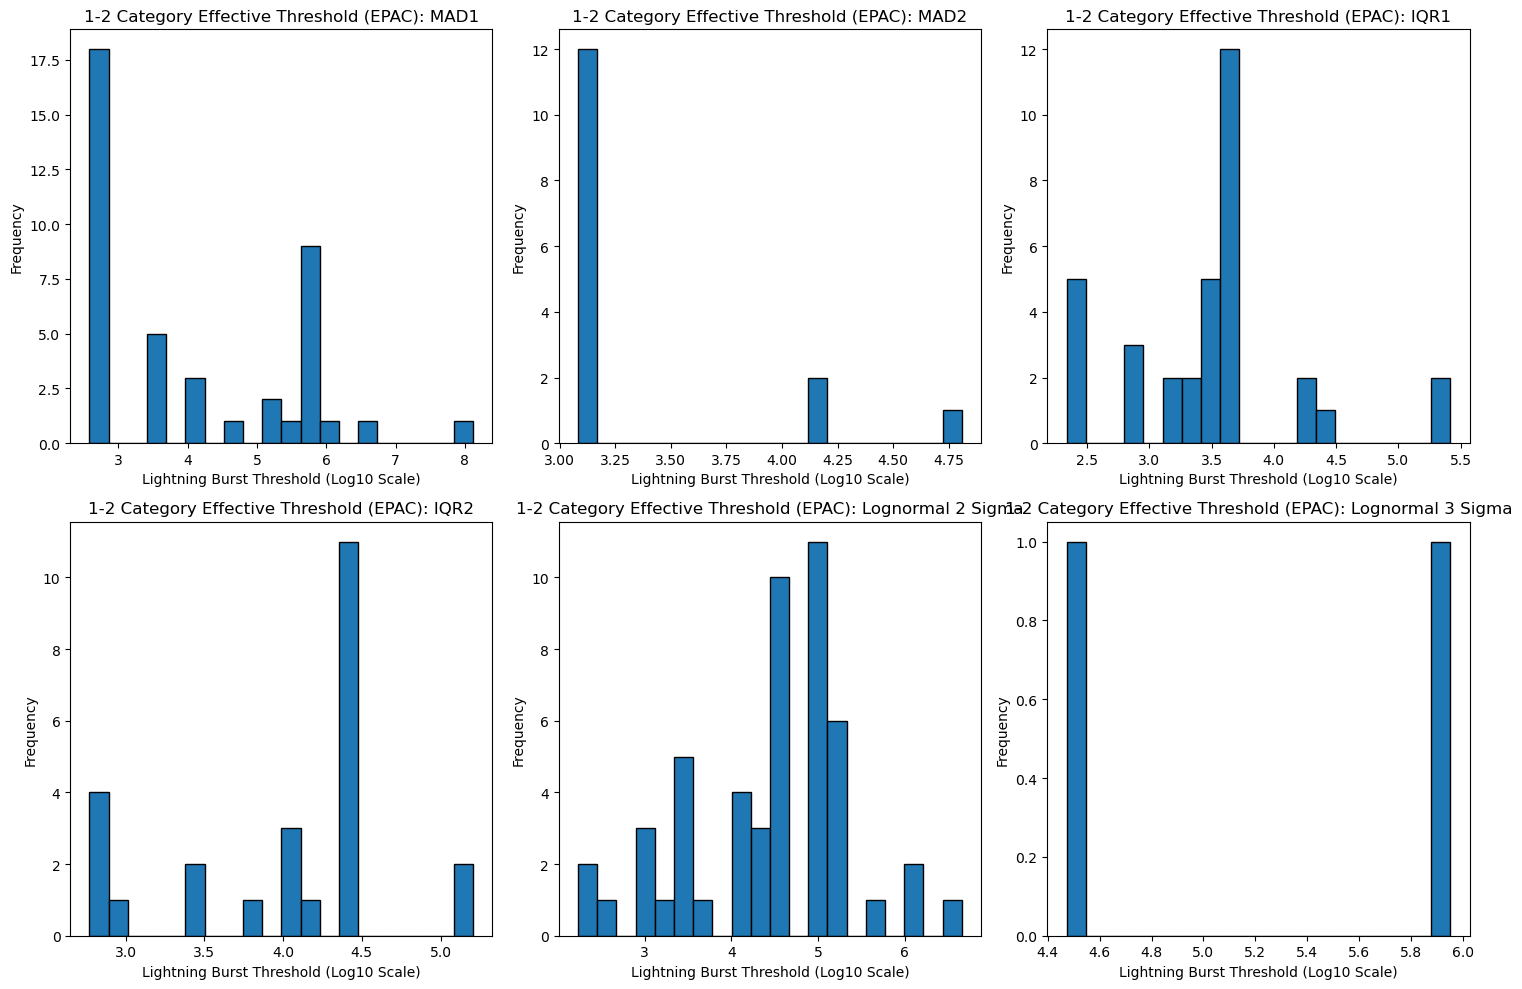

In [91]:
# Plot threshold value distributions for 1-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_weak1_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"1-2 Category Effective Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [93]:
# Get mean and 2 standard dev - 1-2 categories
epac_weak1_effective_summary = create_basin_summary(epac_weak1_effective_lightning, "1-2", "EPAC")
epac_weak1_effective_summary

,Basin,Category Group,Threshold,Mean,Std Dev,Median,Min,Max,Basin-Category Threshold (Mean-Based),Basin-Category Threshold (Median-Based),Burst Count,Timebin Count,Burst Percentage
0,EPAC,1-2,mad1,4.162957,1.547052,3.652740,2.720473,8.258979,7.257060,6.746844,34,68,50.00
1,EPAC,1-2,mad2,3.379361,0.545723,3.125938,3.125938,4.852030,4.470807,4.217384,25,68,36.76
2,EPAC,1-2,iqr1,3.545660,0.716110,3.612965,2.414157,5.493061,4.977881,5.045186,42,68,61.76
3,EPAC,1-2,iqr2,4.055095,0.717920,4.453341,2.831480,5.268244,5.490936,5.889181,15,68,22.06
4,EPAC,1-2,logn1,4.525435,0.957033,4.560759,2.343750,6.767766,6.439500,6.474824,51,68,75.00
5,EPAC,1-2,logn2,5.248504,1.044348,5.248504,4.510039,5.986970,7.337200,7.337200,2,68,2.94


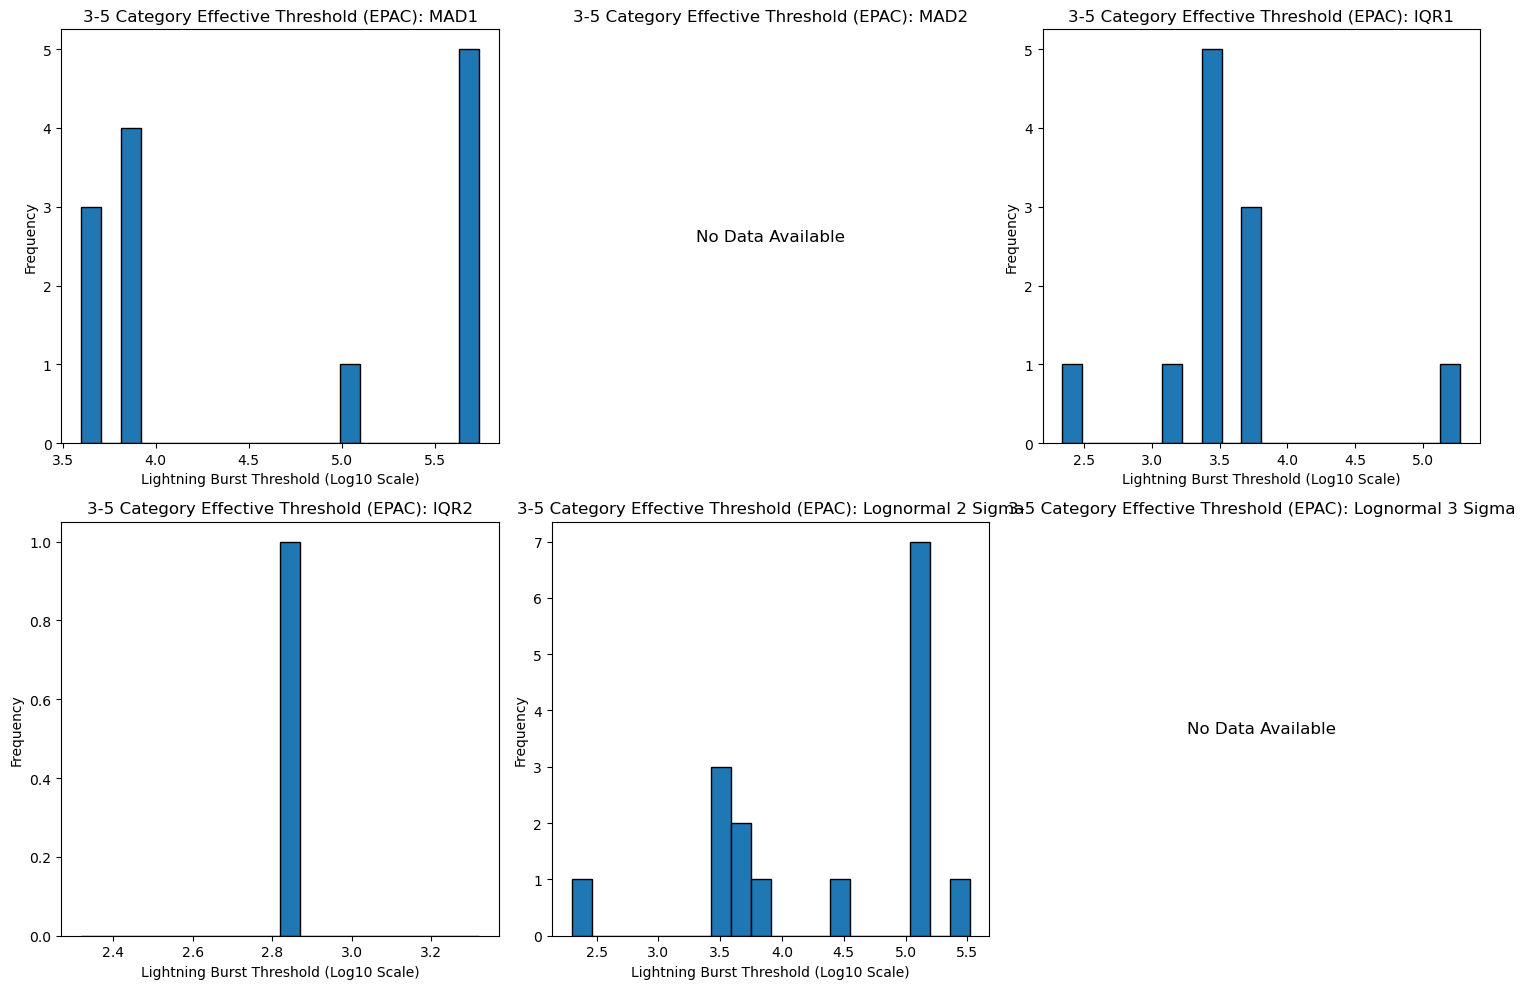

In [94]:
# Plot threshold value distributions for 3-5 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_strong_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"3-5 Category Effective Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [96]:
# Get mean and 2 standard dev - 3-5 categories
epac_strong_effective_summary = create_basin_summary(epac_strong_effective_lightning, "3-5", "EPAC")
epac_strong_effective_summary

,Basin,Category Group,Threshold,Mean,Std Dev,Median,Min,Max,Basin-Category Threshold (Mean-Based),Basin-Category Threshold (Median-Based),Burst Count,Timebin Count,Burst Percentage
0,EPAC,3-5,mad1,4.683494,0.983965,3.960585,3.652740,5.792262,6.651423,5.928514,11,23,47.83
1,EPAC,3-5,mad2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,23,4.35
2,EPAC,3-5,iqr1,3.649424,0.696790,3.524627,2.414157,5.348297,5.043004,4.918208,13,23,56.52
3,EPAC,3-5,iqr2,2.844409,NaN,2.844409,2.844409,2.844409,NaN,NaN,0,23,0.00
4,EPAC,3-5,logn1,4.404095,0.920568,4.816549,2.379402,5.598135,6.245231,6.657686,16,23,69.57
5,EPAC,3-5,logn2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,23,0.00


Let's apply the basin-level effective threshold.

In [99]:
# 0-2 categories
epac_weak0_summary, epac_weak0_eff_bursts_mean, epac_weak0_eff_summary_mean, epac_weak0_eff_bursts_median, epac_weak0_eff_summary_median = summarize_threshold_eval(epac_weak0_summary, epac_weak0_lightning, threshold_data = epac_weak0_effective_summary, threshold_type="effective")
epac_weak0_summary

,Basin,Category Group,Threshold,Mean,Std Dev,Median,Min,Max,Basin-Category Threshold (Mean-Based),Basin-Category Threshold (Median-Based),...,Mean-Based Effective Threshold Bursts_x,Mean-Based Effective Threshold Burst Percentage_x,Median-Based Effective Threshold Bursts_x,Median-Based Effective Threshold Burst Percentage_x,Basin-Category Effective Threshold (Mean-Based)_y,Basin-Category Effective Threshold (Median-Based)_y,Mean-Based Effective Threshold Bursts_y,Mean-Based Effective Threshold Burst Percentage_y,Median-Based Effective Threshold Bursts_y,Median-Based Effective Threshold Burst Percentage_y
0,EPAC,0-2,mad1,6.527584,2.173121,6.668218,0.693147,10.962409,10.873827,11.014461,...,0,0.00,0,0.00,8.003309,7.827488,0,0.00,0,0.00
1,EPAC,0-2,mad2,7.576961,2.544147,7.612680,0.693147,12.785568,12.665256,12.700975,...,23,0.60,113,2.94,6.682197,5.900785,23,0.60,113,2.94
2,EPAC,0-2,iqr1,5.592081,1.602030,5.703782,0.693147,9.045240,8.796140,8.907842,...,170,4.42,157,4.08,5.631462,5.689922,170,4.42,157,4.08
3,EPAC,0-2,iqr2,6.660095,1.929695,6.775983,0.693147,10.829707,10.519485,10.635373,...,140,3.64,72,1.87,5.770032,6.255733,140,3.64,72,1.87
4,EPAC,0-2,logn1,5.233589,1.270183,5.285497,0.693147,7.998327,7.773955,7.825864,...,18,0.47,27,0.70,6.732013,6.643753,18,0.47,27,0.70
5,EPAC,0-2,logn2,6.606666,1.598939,6.761672,0.693147,9.996606,9.804544,9.959551,...,16,0.42,3,0.08,6.809973,7.171973,16,0.42,3,0.08


In [100]:
epac_weak0_eff_summary_mean.query('iqr1_bursts > 0')

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
3,EPAC_11_10,0,1,8.003309,6.682197,20,17,5.631462,5.770032,1,1,6.732013,6.809973,124,0.0,0.81,16.13,13.71,0.81,0.81
4,EPAC_11_11,0,2,8.003309,6.682197,11,10,5.631462,5.770032,0,0,6.732013,6.809973,48,0.0,4.17,22.92,20.83,0.00,0.00
5,EPAC_11_13,0,0,8.003309,6.682197,9,8,5.631462,5.770032,0,0,6.732013,6.809973,54,0.0,0.00,16.67,14.81,0.00,0.00
6,EPAC_11_2,0,0,8.003309,6.682197,1,1,5.631462,5.770032,0,0,6.732013,6.809973,47,0.0,0.00,2.13,2.13,0.00,0.00
14,EPAC_12_3,0,0,8.003309,6.682197,4,3,5.631462,5.770032,0,0,6.732013,6.809973,41,0.0,0.00,9.76,7.32,0.00,0.00
19,EPAC_13_13,0,0,8.003309,6.682197,3,3,5.631462,5.770032,0,0,6.732013,6.809973,58,0.0,0.00,5.17,5.17,0.00,0.00
20,EPAC_13_17,0,3,8.003309,6.682197,27,23,5.631462,5.770032,2,2,6.732013,6.809973,207,0.0,1.45,13.04,11.11,0.97,0.97
27,EPAC_14_11,0,0,8.003309,6.682197,7,5,5.631462,5.770032,0,0,6.732013,6.809973,137,0.0,0.00,5.11,3.65,0.00,0.00
28,EPAC_14_18,0,0,8.003309,6.682197,1,1,5.631462,5.770032,0,0,6.732013,6.809973,98,0.0,0.00,1.02,1.02,0.00,0.00
33,EPAC_15_12,0,0,8.003309,6.682197,2,2,5.631462,5.770032,0,0,6.732013,6.809973,103,0.0,0.00,1.94,1.94,0.00,0.00


Let's do the same for the other 2 category groupings.

In [101]:
# 1-2 categories
epac_weak1_summary, epac_weak1_eff_bursts_mean, epac_weak1_eff_summary_mean, epac_weak1_eff_bursts_median, epac_weak1_eff_summary_median = summarize_threshold_eval(epac_weak1_summary, epac_weak1_lightning, threshold_data = epac_weak1_effective_summary, threshold_type="effective")
epac_weak1_summary

,Basin,Category Group,Threshold,Mean,Std Dev,Median,Min,Max,Basin-Category Threshold (Mean-Based),Basin-Category Threshold (Median-Based),...,Mean-Based Threshold Bursts,Mean-Based Threshold Burst Percentage,Median-Based Threshold Bursts,Median-Based Threshold Burst Percentage,Basin-Category Effective Threshold (Mean-Based),Basin-Category Effective Threshold (Median-Based),Mean-Based Effective Threshold Bursts,Mean-Based Effective Threshold Burst Percentage,Median-Based Effective Threshold Bursts,Median-Based Effective Threshold Burst Percentage
0,EPAC,1-2,mad1,6.119381,2.165851,6.063117,0.693147,10.962409,10.451083,10.394819,...,0,0.0,0,0.0,7.257060,6.746844,1,0.06,2,0.13
1,EPAC,1-2,mad2,7.104991,2.543813,7.004327,0.693147,12.785568,12.192618,12.091953,...,0,0.0,0,0.0,4.470807,4.217384,107,6.85,146,9.35
2,EPAC,1-2,iqr1,5.246400,1.588451,5.172376,0.693147,9.045240,8.423303,8.349279,...,0,0.0,0,0.0,4.977881,5.045186,63,4.04,61,3.91
3,EPAC,1-2,iqr2,6.251145,1.922062,6.190817,0.693147,10.829707,10.095269,10.034941,...,0,0.0,0,0.0,5.490936,5.889181,30,1.92,14,0.90
4,EPAC,1-2,logn1,4.931581,1.255843,4.967780,0.693147,7.998327,7.443267,7.479467,...,0,0.0,0,0.0,6.439500,6.474824,3,0.19,3,0.19
5,EPAC,1-2,logn2,6.227157,1.591641,6.221871,0.693147,9.996606,9.410440,9.405154,...,0,0.0,0,0.0,7.337200,7.337200,1,0.06,1,0.06


In [103]:
# 3-5 categories
epac_strong_summary, epac_strong_eff_bursts_mean, epac_strong_eff_summary_mean, epac_strong_eff_bursts_median, epac_strong_eff_summary_median = summarize_threshold_eval(epac_strong_summary, epac_strong_lightning, threshold_data = epac_strong_effective_summary, threshold_type="effective")
epac_strong_summary

,Basin,Category Group,Threshold,Mean,Std Dev,Median,Min,Max,Basin-Category Threshold (Mean-Based),Basin-Category Threshold (Median-Based),...,Mean-Based Threshold Bursts,Mean-Based Threshold Burst Percentage,Median-Based Threshold Bursts,Median-Based Threshold Burst Percentage,Basin-Category Effective Threshold (Mean-Based),Basin-Category Effective Threshold (Median-Based),Mean-Based Effective Threshold Bursts,Mean-Based Effective Threshold Burst Percentage,Median-Based Effective Threshold Bursts,Median-Based Effective Threshold Burst Percentage
0,EPAC,3-5,mad1,5.719598,1.635318,5.792262,0.693147,10.223271,8.990233,9.062898,...,0,0.0,0,0.0,6.651423,5.928514,0,0.00,2,0.14
1,EPAC,3-5,mad2,6.603652,1.907559,6.677852,0.693147,11.946037,10.418769,10.492969,...,0,0.0,0,0.0,NaN,NaN,0,0.00,0,0.00
2,EPAC,3-5,iqr1,4.990127,1.245536,5.172376,0.693147,8.230524,7.481199,7.663448,...,0,0.0,0,0.0,5.043004,4.918208,25,1.79,31,2.22
3,EPAC,3-5,iqr2,5.898325,1.480719,6.190817,0.693147,9.885795,8.859763,9.152255,...,0,0.0,0,0.0,NaN,NaN,0,0.00,0,0.00
4,EPAC,3-5,logn1,4.755955,0.985998,5.033171,0.693147,6.999298,6.727951,7.005167,...,0,0.0,0,0.0,6.245231,6.657686,0,0.00,0,0.00
5,EPAC,3-5,logn2,5.963515,1.226997,6.285003,0.693147,8.822181,8.417509,8.738997,...,0,0.0,0,0.0,NaN,NaN,0,0.00,0,0.00


In [104]:
epac_strong_eff_summary_mean.query('iqr1_bursts > 0')

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
17,EPAC_15_20,0,0,6.651423,NaN,4,0,5.043004,NaN,0,0,6.245231,NaN,67,0.0,0.0,5.97,0.0,0.0,0.0
18,EPAC_15_22,0,0,6.651423,NaN,1,0,5.043004,NaN,0,0,6.245231,NaN,54,0.0,0.0,1.85,0.0,0.0,0.0
26,EPAC_18_14,0,0,6.651423,NaN,6,0,5.043004,NaN,0,0,6.245231,NaN,212,0.0,0.0,2.83,0.0,0.0,0.0
31,EPAC_18_21,0,0,6.651423,NaN,1,0,5.043004,NaN,0,0,6.245231,NaN,29,0.0,0.0,3.45,0.0,0.0,0.0
32,EPAC_18_24,0,0,6.651423,NaN,13,0,5.043004,NaN,0,0,6.245231,NaN,77,0.0,0.0,16.88,0.0,0.0,0.0


Concatenate the three dataframes into one for easier comparison at the basin level.

In [105]:
epac_basin_bursts = pd.concat([epac_weak0_summary, epac_weak1_summary, epac_strong_summary], ignore_index=True)
epac_basin_bursts

,Basin,Category Group,Threshold,Mean,Std Dev,Median,Min,Max,Basin-Category Threshold (Mean-Based),Basin-Category Threshold (Median-Based),...,Mean-Based Effective Threshold Bursts_y,Mean-Based Effective Threshold Burst Percentage_y,Median-Based Effective Threshold Bursts_y,Median-Based Effective Threshold Burst Percentage_y,Basin-Category Effective Threshold (Mean-Based),Basin-Category Effective Threshold (Median-Based),Mean-Based Effective Threshold Bursts,Mean-Based Effective Threshold Burst Percentage,Median-Based Effective Threshold Bursts,Median-Based Effective Threshold Burst Percentage
0,EPAC,0-2,mad1,6.527584,2.173121,6.668218,0.693147,10.962409,10.873827,11.014461,...,0.0,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN
1,EPAC,0-2,mad2,7.576961,2.544147,7.612680,0.693147,12.785568,12.665256,12.700975,...,23.0,0.60,113.0,2.94,NaN,NaN,NaN,NaN,NaN,NaN
2,EPAC,0-2,iqr1,5.592081,1.602030,5.703782,0.693147,9.045240,8.796140,8.907842,...,170.0,4.42,157.0,4.08,NaN,NaN,NaN,NaN,NaN,NaN
3,EPAC,0-2,iqr2,6.660095,1.929695,6.775983,0.693147,10.829707,10.519485,10.635373,...,140.0,3.64,72.0,1.87,NaN,NaN,NaN,NaN,NaN,NaN
4,EPAC,0-2,logn1,5.233589,1.270183,5.285497,0.693147,7.998327,7.773955,7.825864,...,18.0,0.47,27.0,0.70,NaN,NaN,NaN,NaN,NaN,NaN
5,EPAC,0-2,logn2,6.606666,1.598939,6.761672,0.693147,9.996606,9.804544,9.959551,...,16.0,0.42,3.0,0.08,NaN,NaN,NaN,NaN,NaN,NaN
6,EPAC,1-2,mad1,6.119381,2.165851,6.063117,0.693147,10.962409,10.451083,10.394819,...,NaN,NaN,NaN,NaN,7.257060,6.746844,1.0,0.06,2.0,0.13
7,EPAC,1-2,mad2,7.104991,2.543813,7.004327,0.693147,12.785568,12.192618,12.091953,...,NaN,NaN,NaN,NaN,4.470807,4.217384,107.0,6.85,146.0,9.35
8,EPAC,1-2,iqr1,5.246400,1.588451,5.172376,0.693147,9.045240,8.423303,8.349279,...,NaN,NaN,NaN,NaN,4.977881,5.045186,63.0,4.04,61.0,3.91
9,EPAC,1-2,iqr2,6.251145,1.922062,6.190817,0.693147,10.829707,10.095269,10.034941,...,NaN,NaN,NaN,NaN,5.490936,5.889181,30.0,1.92,14.0,0.90


In [106]:
epac_basin_bursts.to_csv("data/epac_basin_bursts.csv", index=False)

---------------------

### ATL Basin
Let's perform the same analysis for the ATL basin. Start by filtering for the ATL TCs.

In [107]:
# Get list of ATL storm codes
atl_data = innercore_data.filter(pl.col("basin") == "ATL")
atl_storm_codes = atl_data["storm_code"].unique()
atl_storm_codes.head(5)

storm_code
str
"""ATL_20_19"""
"""ATL_12_8"""
"""ATL_12_11"""
"""ATL_11_17"""
"""ATL_17_16"""


In [ ]:
# Filter aggregated table to ATL only
atl_tc_summary = tc_summary[tc_summary["storm_code"].isin(atl_storm_codes)]
atl_tc_summary.head()

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
7,ATL_15_4,Danny,0,0,6.879356,7.977968,2,0,5.958941,7.046317,...,0,5.741565,7.258307,65,0.0,0.0,3.08,0.0,6.15,0.0
8,ATL_10_17,Otto,0,0,8.435549,9.821844,0,0,6.852734,8.140767,...,0,6.020799,7.572206,75,0.0,0.0,0.00,0.0,1.33,0.0
12,ATL_12_18,Sandy,0,0,4.158883,4.852030,0,0,4.280869,5.101774,...,0,3.522885,4.439763,20,0.0,0.0,0.00,0.0,0.00,0.0
18,ATL_20_16,Nana,0,0,10.345524,11.896122,0,0,8.900928,10.576853,...,0,7.884307,9.851361,97,0.0,0.0,0.00,0.0,0.00,0.0
20,ATL_20_14,Marco,0,0,10.094307,11.834010,0,0,7.996065,9.648507,...,0,6.764857,8.575750,75,0.0,0.0,0.00,0.0,1.33,0.0


In [ ]:
# Filter lightning point data to ATL only
atl_bursts = bursts[bursts["storm_code"].isin(atl_storm_codes)]
atl_bursts.head()

,time_bin,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,...,iqr1_threshold,iqr2_threshold,burst_mad1,burst_mad2,mad1_threshold,mad2_threshold,burst_logn1,burst_logn2,logn1_threshold,logn2_threshold
0,2010-06-26 09:00:00,ATL_10_1,2,2010,6,26,9,0,17.0,-86.2,...,3.265439,3.908512,False,False,2.720473,3.125938,False,False,3.469047,4.444476
1,2010-06-26 09:30:00,ATL_10_1,13,2010,6,26,9,30,17.0,-86.2,...,3.265439,3.908512,False,False,2.720473,3.125938,False,False,3.469047,4.444476
2,2010-06-26 13:00:00,ATL_10_1,2,2010,6,26,13,0,17.0,-86.2,...,3.265439,3.908512,False,False,2.720473,3.125938,False,False,3.469047,4.444476
3,2010-06-26 13:30:00,ATL_10_1,1,2010,6,26,13,30,17.0,-86.2,...,3.265439,3.908512,False,False,2.720473,3.125938,False,False,3.469047,4.444476
4,2010-06-26 14:30:00,ATL_10_1,1,2010,6,26,14,30,17.0,-86.2,...,3.265439,3.908512,False,False,2.720473,3.125938,False,False,3.469047,4.444476


Let's look at the unweighted threshold distribution (1 occurence per TC) before splitting the timebins by current category.

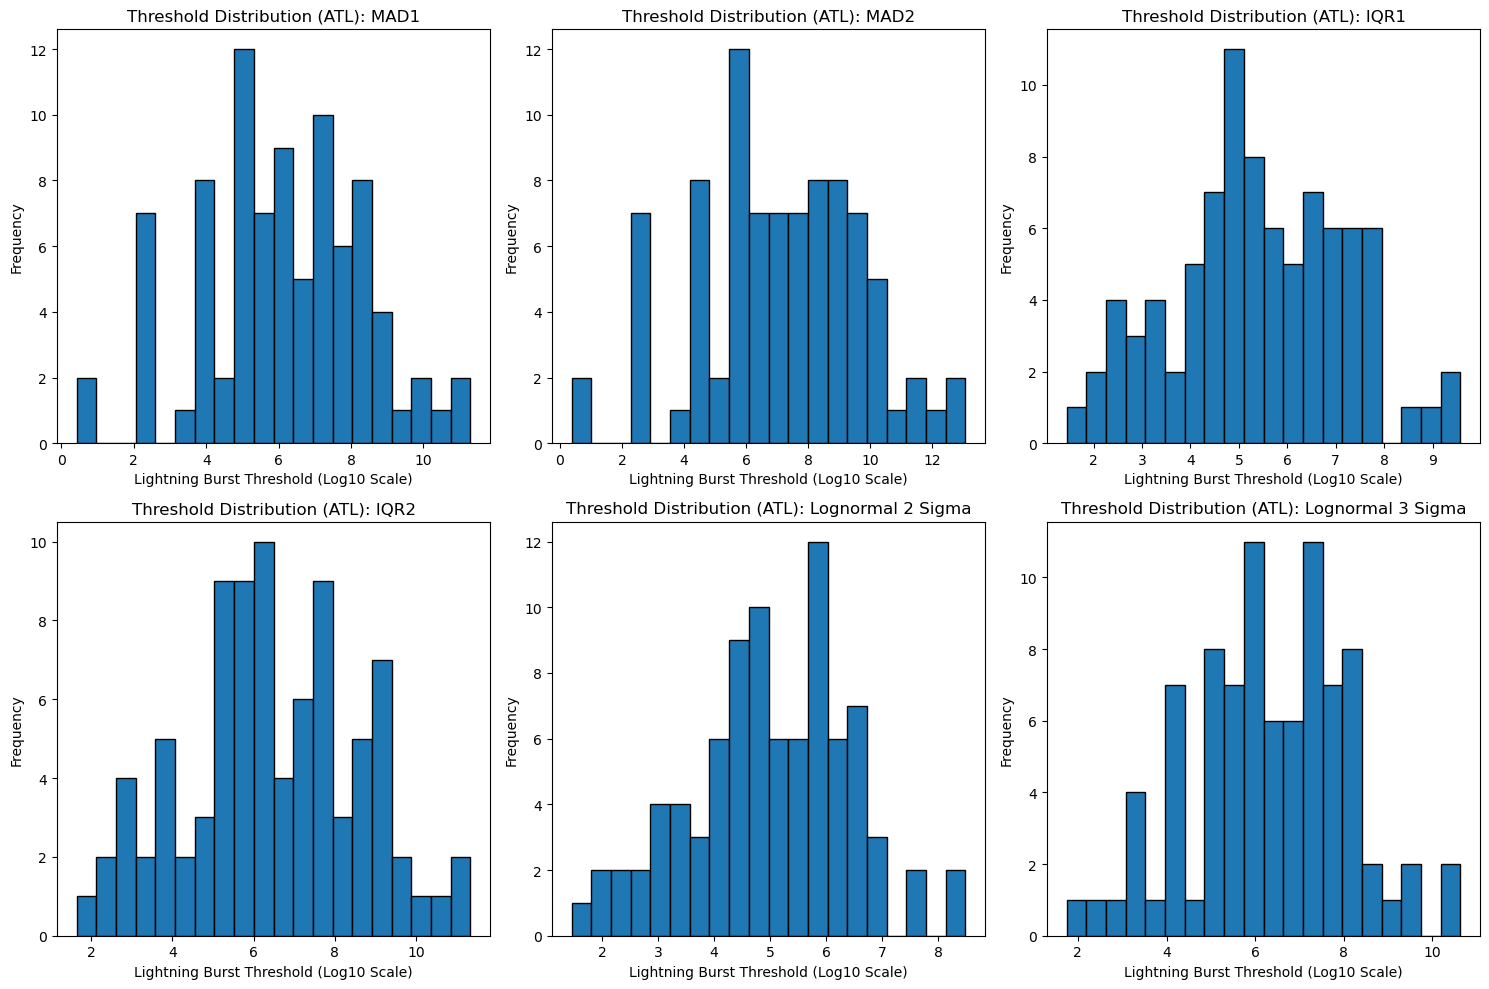

In [111]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(atl_tc_summary, threshold, ax=axes[i])
    axes[i].set_title(f"Threshold Distribution (ATL): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

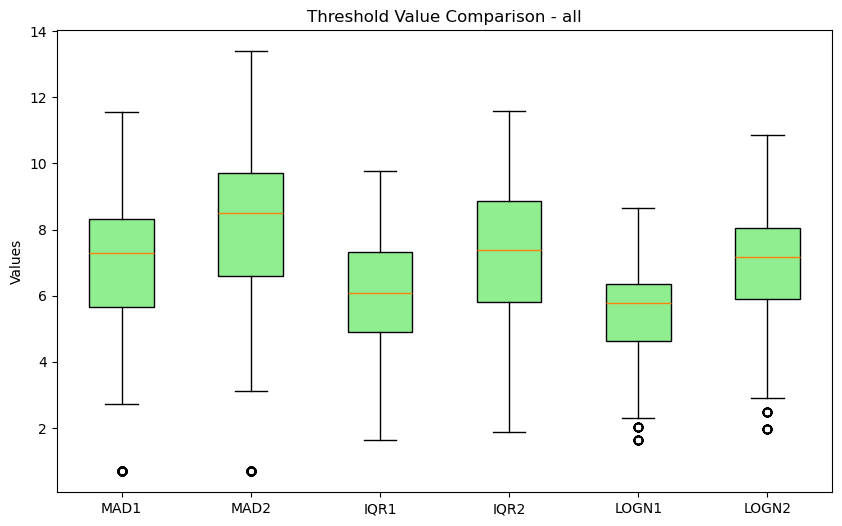

In [113]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(atl_bursts, "all", ax=None)

ideas... fill in later if they're useful at all

Create a summary for the weaker categories and create an initial basin-category threshold defined as 2 standard deviations + the mean or median.

In [115]:
# Group the data into weak and strong category datasets using function
atl_weak0_lightning, atl_weak1_lightning, atl_strong_lightning = group_bins_category(atl_bursts)

7879 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
2969 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
1564 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


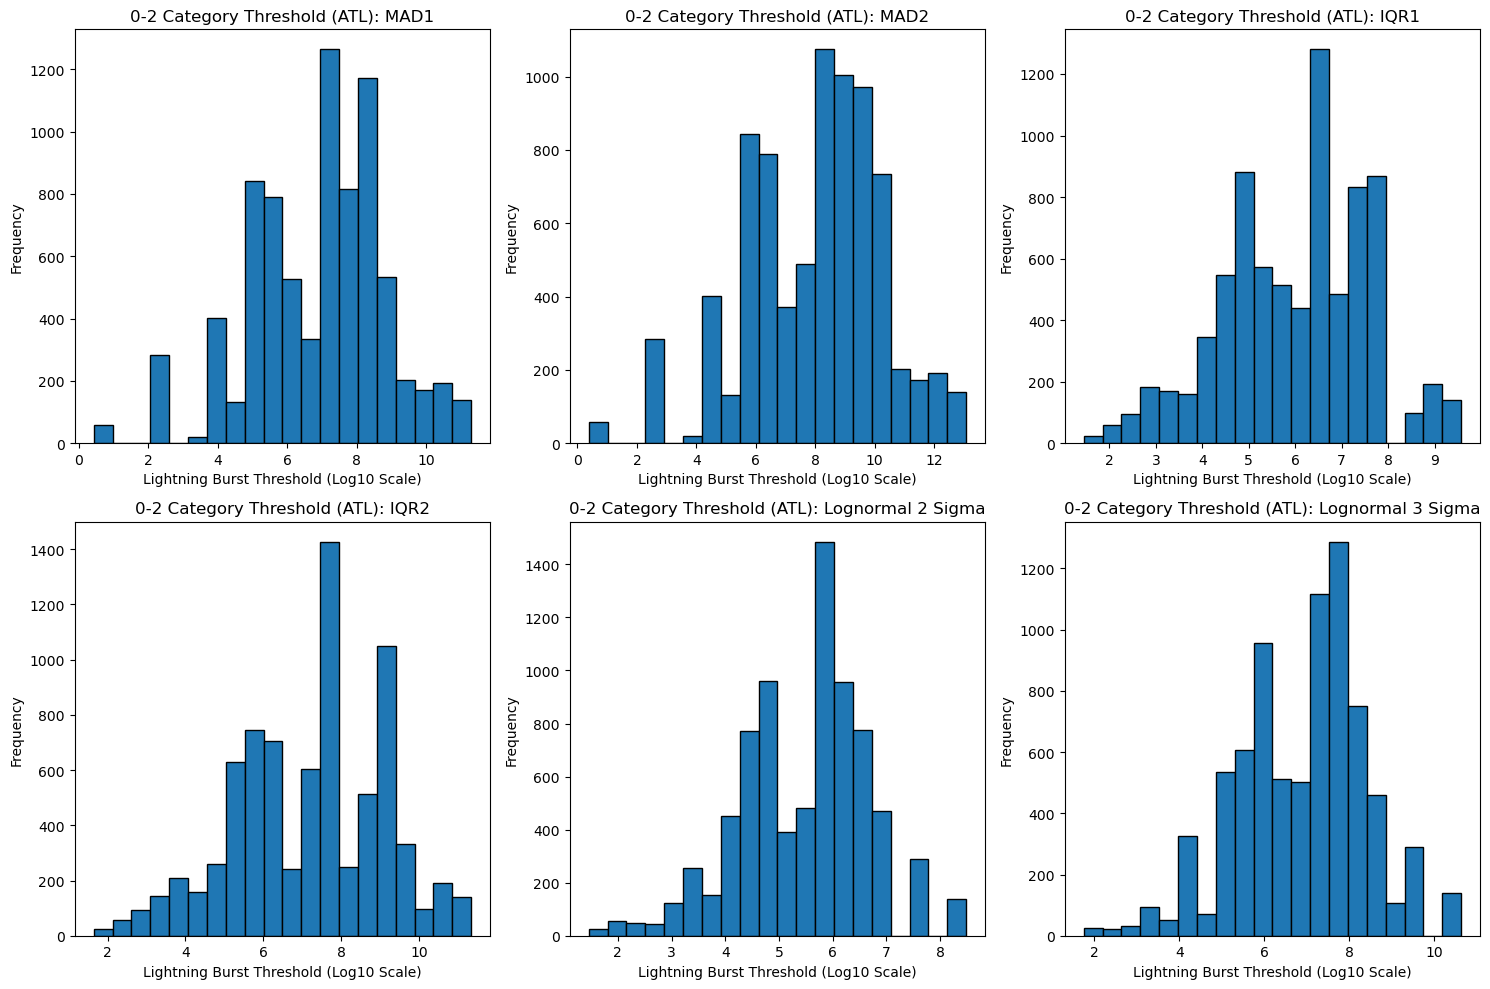

In [116]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(atl_weak0_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Threshold (ATL): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

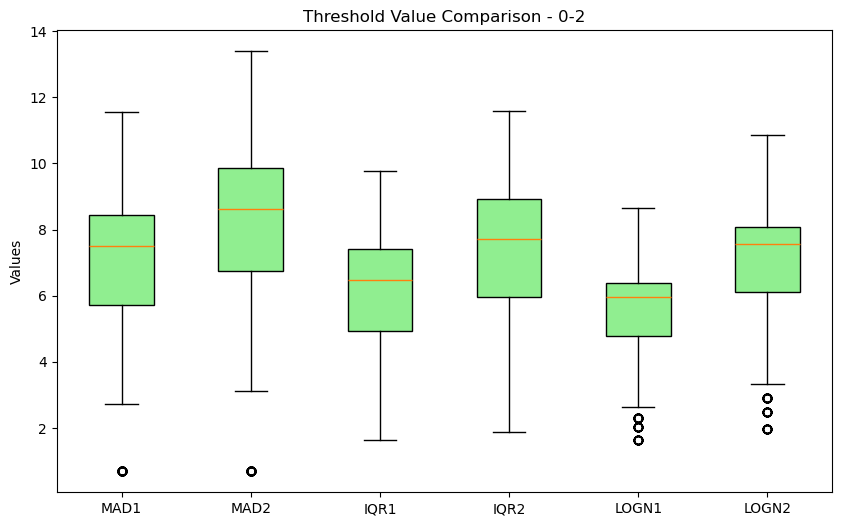

In [117]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(atl_weak0_lightning, "0-2", ax=None)

In [118]:
# Get mean and 2 standard dev - 0-2 categories
atl_weak0_summary = create_basin_summary(atl_weak0_lightning, "0-2", "ATL")
atl_weak0_summary

,Basin,Category Group,Threshold,Mean,Std Dev,Median,Min,Max,Basin-Category Threshold (Mean-Based),Basin-Category Threshold (Median-Based),Burst Count,Timebin Count,Burst Percentage
0,ATL,0-2,mad1,7.120985,1.970386,7.501090,0.693147,11.566724,11.061758,11.441863,111,7879,1.41
1,ATL,0-2,mad2,8.286976,2.294624,8.626454,0.693147,13.390425,12.876223,13.215702,58,7879,0.74
2,ATL,0-2,iqr1,6.206470,1.602419,6.490420,1.647918,9.774169,9.411309,9.695258,159,7879,2.02
3,ATL,0-2,iqr2,7.424062,1.933749,7.710666,1.886611,11.581476,11.291559,11.578163,41,7879,0.52
4,ATL,0-2,logn1,5.636795,1.213463,5.963810,1.630575,8.659291,8.063721,8.390736,230,7879,2.92
5,ATL,0-2,logn2,7.130890,1.523054,7.572206,1.969559,10.852508,10.176999,10.618314,11,7879,0.14
